In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score,StratifiedKFold,KFold
from sklearn.feature_selection import SelectKBest,f_classif,SelectFdr
from sklearn import preprocessing
from sklearn.preprocessing import normalize,RobustScaler, MinMaxScaler,StandardScaler
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform,RandomUniform,Constant
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

In [3]:
# load AUC outcomes
outcomes = pd.read_csv("D:/ErasmusMC/Erasmus MC/Hanarth - IMPRESSING-GBM/Gliotrain/DrugResponsePrediction/GDSC/gdsc_outcomes_oxali.csv")
outcomes = outcomes.drop(['Unnamed: 0'],axis=1)
outcomes = outcomes.set_index(['CELL_LINE_NAME'])
outcomes

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
CELL_LINE_NAME,,,,,,,,,,,,,,,,,,
HCT-116,GDSC2,282,13320856,905936,SIDM00783,COREAD,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.009766,10,1.051629,0.788905,0.101865,-1.547376
HCT-15,GDSC2,282,13320870,905937,SIDM00789,COREAD,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.009766,10,2.161643,0.866811,0.092599,-0.888961
HT-29,GDSC2,282,13320884,905939,SIDM00136,COREAD,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.009766,10,2.446761,0.854751,0.091434,-0.719842
COLO-205,GDSC2,282,13321060,905961,SIDM00826,COREAD,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.009766,10,2.625927,0.879695,0.107523,-0.613567
SW620,GDSC2,282,13321074,905962,SIDM00841,COREAD,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.009766,10,2.101779,0.831321,0.080468,-0.924471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EMC-BAC-2,GDSC2,282,13418699,1503370,SIDM00047,LUAD,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.010005,10,2.304135,0.863922,0.091688,-0.804441
TE-4,GDSC2,282,13418830,1503371,SIDM00250,ESCA,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.010005,10,5.512991,0.993227,0.052770,1.098919
NCC010,GDSC2,282,13418949,1509073,SIDM00231,KIRC,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.010005,10,5.083443,0.981720,0.076835,0.844129


In [4]:
# load expression data
exp = pd.read_csv("D:/ErasmusMC/Erasmus MC/Hanarth - IMPRESSING-GBM/Gliotrain/DrugResponsePrediction/GDSC/gdsc_exp_oxali.csv")
exp = exp.set_index(['Unnamed: 0'])
exp = exp.T
exp

Unnamed: 0,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5
HCT-116,7.571165,2.782633,10.143152,4.166403,3.302627,3.249046,3.006788,8.293391,6.865612,5.225474,...,3.462682,4.407369,3.583040,2.649146,3.082439,3.388990,3.364348,3.291773,9.381200,3.283286
HCT-15,7.578433,3.010716,9.197256,4.200191,3.541792,3.379442,3.722263,8.668989,5.371045,5.387490,...,3.641909,3.249648,4.614347,3.036727,3.729753,3.269010,3.339571,3.216607,8.555360,3.365279
HT-29,7.356123,2.905907,10.404117,4.826544,3.277241,3.159134,5.943386,8.015126,6.307693,5.129012,...,6.046235,3.559006,4.511561,2.706954,6.430082,2.933928,3.256360,3.118281,8.546865,3.183708
COLO-205,7.065005,2.712504,10.363337,5.309871,3.354821,3.306794,3.342182,7.534794,8.555949,7.062869,...,3.481337,3.552700,4.486483,4.111333,5.255268,3.082409,3.137460,2.816710,9.040039,3.243377
SW620,7.822307,3.061145,10.005268,3.993789,3.396529,3.466112,3.282186,8.447974,6.019157,4.778702,...,3.285255,4.041216,4.127283,2.721107,5.687819,3.311553,3.164085,3.567341,8.657871,3.497548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EMC-BAC-2,7.591241,2.901137,9.560943,4.092802,3.307883,3.447297,7.339126,7.931999,5.613537,5.032409,...,3.032801,3.140464,5.007539,2.835314,4.759650,3.149247,3.305257,3.103534,9.300657,3.509603
TE-4,8.327419,2.715187,9.469897,5.079990,3.624926,3.087703,8.460307,8.386517,6.713271,4.807761,...,3.587285,3.532405,3.787383,2.668231,5.084207,3.099270,3.214459,3.221579,9.323354,3.498237
NCC010,5.987799,2.784995,10.052390,3.668912,3.767270,3.085118,5.332890,8.031837,6.249088,4.950251,...,3.369585,3.532607,4.051723,2.621257,4.634649,3.498556,3.384732,2.977642,9.363887,3.320187
RCC-JW,7.529016,3.195540,10.600703,3.997457,4.544972,3.450394,5.279941,7.988237,4.217507,5.345541,...,3.075105,3.789976,4.708105,2.609469,3.816648,3.152940,3.364600,3.126751,10.156730,3.376311


In [6]:
# label for auc
auc_bi = list()
for i in outcomes["AUC"]:
    if i < outcomes["AUC"].median():
        auc_bi.append(0)
    else:
        auc_bi.append(1)
print(auc_bi)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 

In [8]:
# loss function plot
def plt_loss(train_loss,validate_loss,fold_no):
    plt.figure(figsize=(8, 8))
    #plt.subplot(5, 1, fold_no)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(validate_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    #plt.ylim([0,0.6])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


def plt_acc(train_mse,validate_mse,fold_no):
    plt.figure(figsize=(8, 8))
    plt.subplot(5, 1, fold_no)
    plt.plot(train_mse, label='Training Accuracy')
    plt.plot(validate_mse, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('mae')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation mse')


In [9]:
# normalization
Standard = StandardScaler()
MinMax = MinMaxScaler()
Robust = RobustScaler()

In [10]:
# R2 evaluation metric
def R2(observ,pred):
    SSres = 0
    SStot = 0
    for i in range(0,len(observ)):
        yo = observ[i]
        yp = pred[i]
        SSres += (yo-yp)**2
        SStot += (yo-observ.mean())**2
    print(SSres)
    print(SStot)
    r2 = 1-SSres/SStot
    return(r2)

(array([  4.,   2.,   5.,   9.,  14.,  34.,  36., 102., 192., 312.]),
 array([0.534958 , 0.5809788, 0.6269996, 0.6730204, 0.7190412, 0.765062 ,
        0.8110828, 0.8571036, 0.9031244, 0.9491452, 0.995166 ]),
 <BarContainer object of 10 artists>)

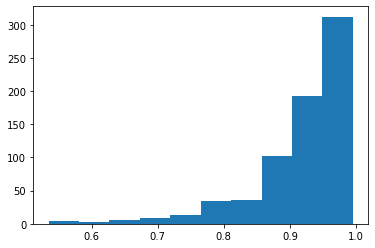

In [11]:
# AUC distribution
plt.hist(outcomes["AUC"])

In [12]:
# AUC norm [0,1]
auc_norm = outcomes["AUC"]
auc_norm = (auc_norm - auc_norm.min())/(auc_norm.max()-auc_norm.min())
auc_norm

CELL_LINE_NAME
HCT-116      0.551809
HCT-15       0.721094
HT-29        0.694888
COLO-205     0.749090
SW620        0.643976
               ...   
EMC-BAC-2    0.714816
TE-4         0.995787
NCC010       0.970783
RCC-JW       0.956520
SNU-61       0.924454
Name: AUC, Length: 710, dtype: float64

In [13]:
# rescale AUC [0,10]
auc_norm = auc_norm*10

(array([  4.,   2.,   5.,   9.,  14.,  34.,  36., 102., 192., 312.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

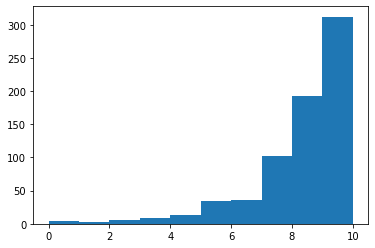

In [14]:
plt.hist(auc_norm)

In [15]:
# model
def gdsc_model(activation1 = "tanh",activation2 = "sigmoid",l2 = 0.001,l1=0.001, opt = "Adam",input_num=17419):
    
    init = GlorotUniform(seed = seed_num)# minval=0, maxval=1,
    
    model = Sequential()
    
    model.add(Dense(1000,activation= activation1,input_shape=(input_num,),#17419
                    kernel_regularizer=regularizers.l2(l2),activity_regularizer=regularizers.l1(l1),
                    kernel_initializer= init))#             
    
    model.add(Dropout(0.3))
    
    model.add(Dense(100, activation=activation2,kernel_initializer=init))
                    
    model.add(Dropout(0.1))
    
    model.add(Dense(1, activation= activation2,kernel_initializer=init))
    
    model.compile(loss='mean_squared_error',optimizer= opt,metrics=['mae']) #,mean_squared_logarithmic_error
    
    return model

------------------------------------------------------------------------
Training for fold 1, seed 400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 30.0657 - mean_absolute_error: 4.8465 - val_loss: 5.9203 - val_mean_absolute_error: 1.9476
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.4419 - mean_absolute_error: 2.0557 - val_loss: 2.7501 - val_mean_absolute_error: 1.2174
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.4438 - mean_absolute_error: 1.5333 - val_loss: 2.9746 - val_mean_absolute_error: 1.3507
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0481 - mean_absolute_error: 1.0614 - val_loss: 2.4987 - val_mean_absolute_error: 1.0982
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.5765 - mean_absolute_error: 0.8586 - val_loss: 2.2007 - val_mean_absolute_error: 1.0729
Epoch 6/50
568/5

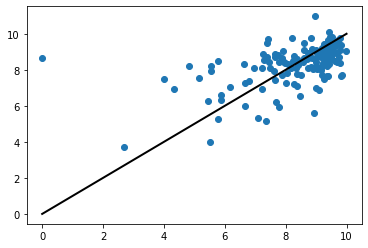

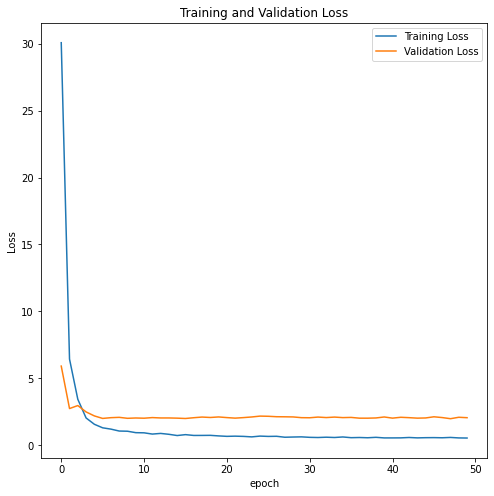

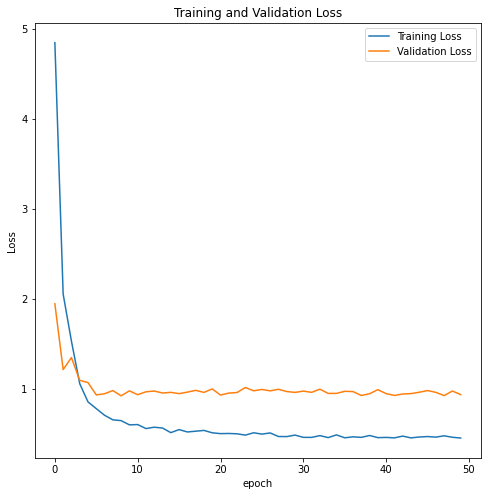

------------------------------------------------------------------------
Training for fold 2, seed 400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 29.2175 - mean_absolute_error: 4.7194 - val_loss: 5.9582 - val_mean_absolute_error: 2.0888
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.0776 - mean_absolute_error: 1.9710 - val_loss: 2.6133 - val_mean_absolute_error: 1.2959
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.5884 - mean_absolute_error: 1.5628 - val_loss: 2.2816 - val_mean_absolute_error: 1.2045
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.2016 - mean_absolute_error: 1.0707 - val_loss: 1.9725 - val_mean_absolute_error: 1.0359
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.8911 - mean_absolute_error: 0.9325 - val_loss: 1.8645 - val_mean_absolute_error: 1.0537
Epoch 6/50
568/5

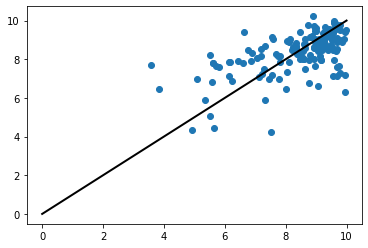

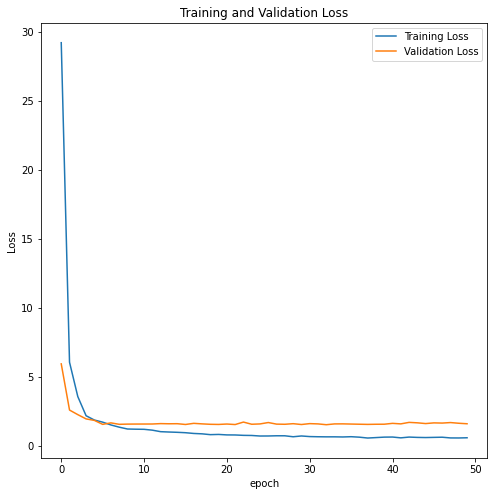

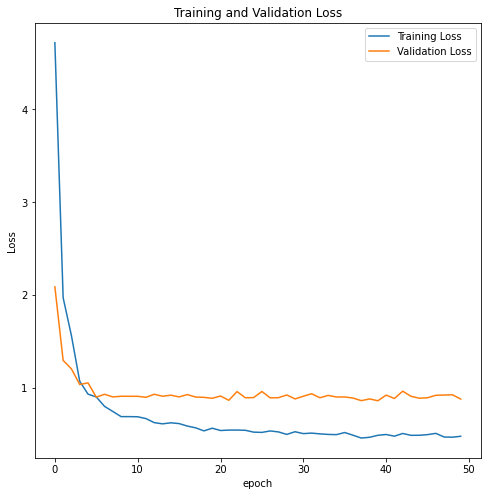

------------------------------------------------------------------------
Training for fold 3, seed 400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 29.5051 - mean_absolute_error: 4.7525 - val_loss: 6.0868 - val_mean_absolute_error: 2.0944
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.2318 - mean_absolute_error: 1.7690 - val_loss: 3.0361 - val_mean_absolute_error: 1.3271
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3223 - mean_absolute_error: 1.4588 - val_loss: 2.3684 - val_mean_absolute_error: 1.2007
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0473 - mean_absolute_error: 1.0277 - val_loss: 2.3384 - val_mean_absolute_error: 1.0895
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6471 - mean_absolute_error: 0.8762 - val_loss: 2.0622 - val_mean_absolute_error: 1.0922
Epoch 6/50
568/5

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6423 - mean_absolute_error: 0.4992 - val_loss: 1.8887 - val_mean_absolute_error: 0.9920
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6255 - mean_absolute_error: 0.4831 - val_loss: 1.8619 - val_mean_absolute_error: 0.9372
Spearman correlation: 0.509


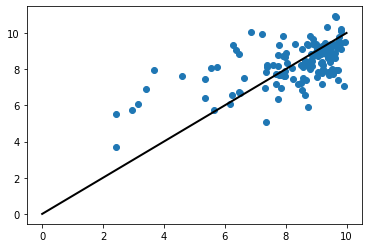

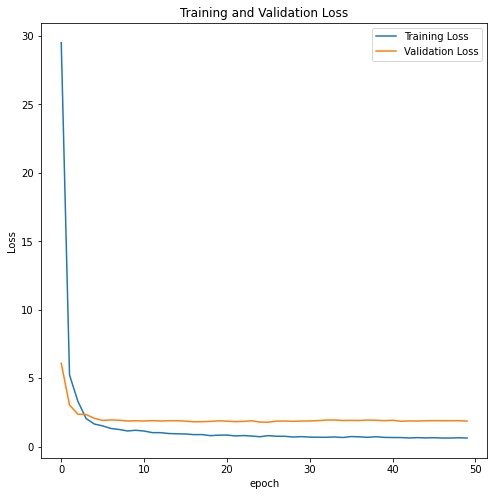

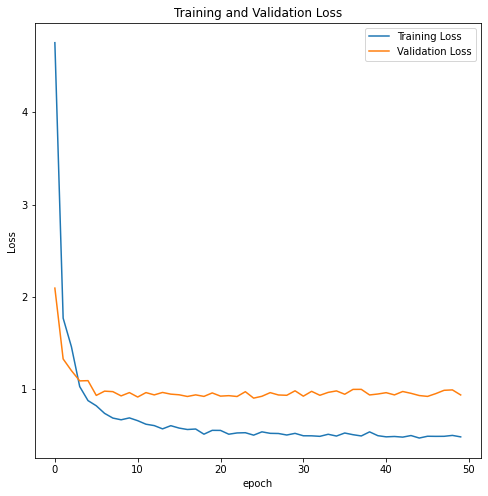

------------------------------------------------------------------------
Training for fold 4, seed 400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 29.0849 - mean_absolute_error: 4.7352 - val_loss: 5.5142 - val_mean_absolute_error: 1.9896
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.7233 - mean_absolute_error: 1.9081 - val_loss: 4.1784 - val_mean_absolute_error: 1.5791
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.2912 - mean_absolute_error: 1.5097 - val_loss: 3.1994 - val_mean_absolute_error: 1.3246
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9628 - mean_absolute_error: 1.0225 - val_loss: 2.9687 - val_mean_absolute_error: 1.1943
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.5792 - mean_absolute_error: 0.8556 - val_loss: 2.8438 - val_mean_absolute_error: 1.2023
Epoch 6/50
568/5

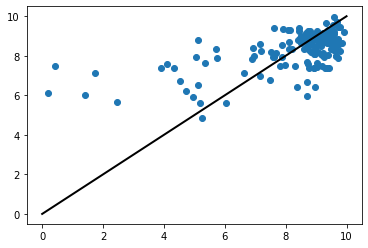

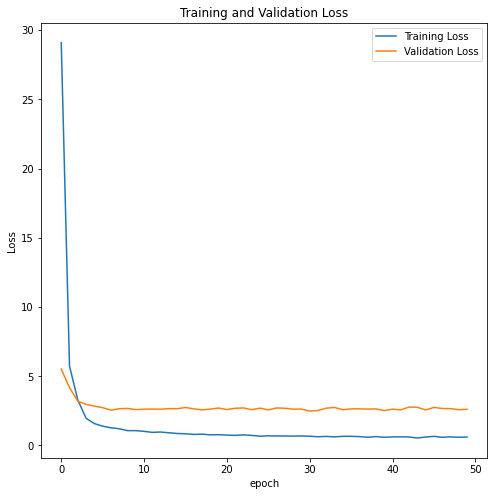

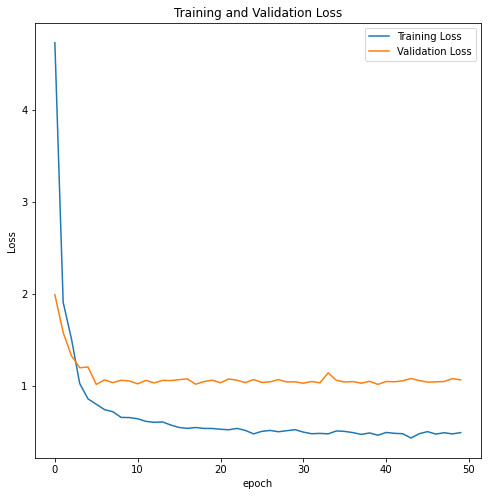

------------------------------------------------------------------------
Training for fold 5, seed 400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 29.1541 - mean_absolute_error: 4.6801 - val_loss: 4.1287 - val_mean_absolute_error: 1.7014
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.4370 - mean_absolute_error: 1.8548 - val_loss: 2.5685 - val_mean_absolute_error: 1.2487
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3777 - mean_absolute_error: 1.4987 - val_loss: 1.9478 - val_mean_absolute_error: 1.0432
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.1577 - mean_absolute_error: 1.0605 - val_loss: 1.7109 - val_mean_absolute_error: 0.9372
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6387 - mean_absolute_error: 0.8683 - val_loss: 1.8340 - val_mean_absolute_error: 1.0303
Epoch 6/50
568/5

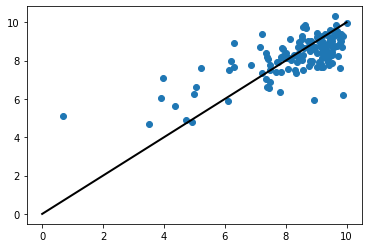

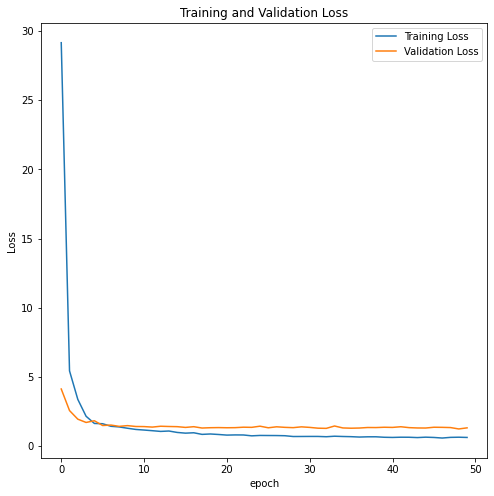

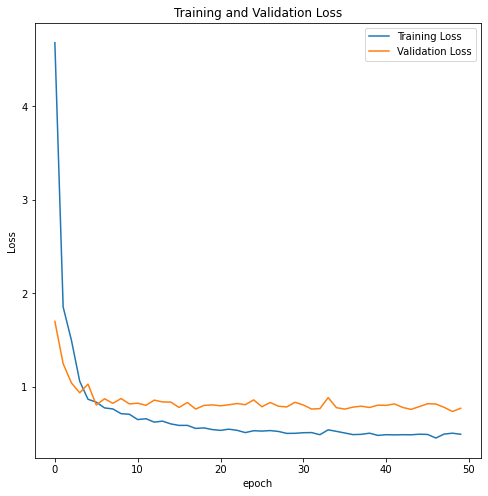

Overall spearman correlation: 0.520
------------------------------------------------------------------------
Training for fold 1, seed 500 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 26.1177 - mean_absolute_error: 4.4089 - val_loss: 7.3781 - val_mean_absolute_error: 2.2995
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.5596 - mean_absolute_error: 1.8747 - val_loss: 3.2647 - val_mean_absolute_error: 1.4356
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3655 - mean_absolute_error: 1.5385 - val_loss: 2.7173 - val_mean_absolute_error: 1.1959
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0197 - mean_absolute_error: 1.0280 - val_loss: 2.8497 - val_mean_absolute_error: 1.1857
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.5355 - mean_absolute_error: 0.8389 - val_loss: 2.5524 - val_mean_abs

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.5467 - mean_absolute_error: 0.4320 - val_loss: 2.3272 - val_mean_absolute_error: 1.0534
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.5644 - mean_absolute_error: 0.4591 - val_loss: 2.3508 - val_mean_absolute_error: 1.0705
Spearman correlation: 0.454


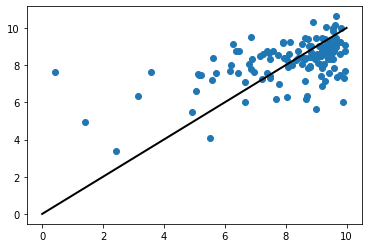

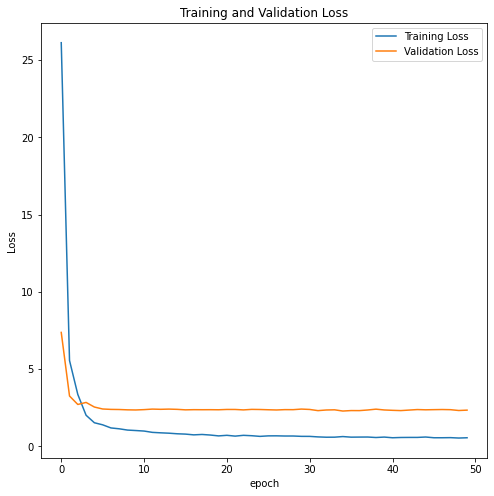

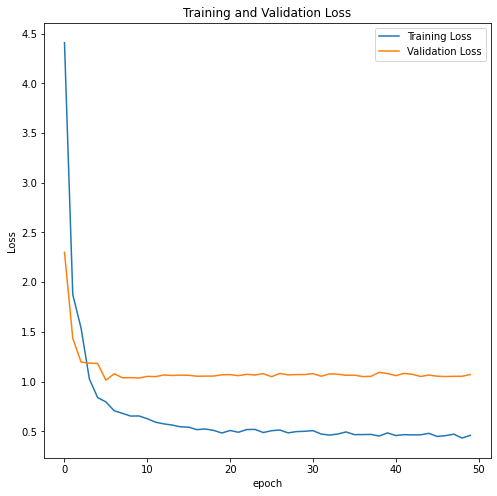

------------------------------------------------------------------------
Training for fold 2, seed 500 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 26.9674 - mean_absolute_error: 4.5382 - val_loss: 7.8127 - val_mean_absolute_error: 2.3627
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.6990 - mean_absolute_error: 1.8946 - val_loss: 4.0114 - val_mean_absolute_error: 1.5827
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.6337 - mean_absolute_error: 1.5877 - val_loss: 2.2504 - val_mean_absolute_error: 1.0599
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.1779 - mean_absolute_error: 1.0848 - val_loss: 2.3466 - val_mean_absolute_error: 1.0386
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6513 - mean_absolute_error: 0.8931 - val_loss: 2.4011 - val_mean_absolute_error: 1.1482
Epoch 6/50
568/5

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.5759 - mean_absolute_error: 0.4662 - val_loss: 1.9453 - val_mean_absolute_error: 0.8650
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.5593 - mean_absolute_error: 0.4641 - val_loss: 1.9214 - val_mean_absolute_error: 0.8481
Spearman correlation: 0.592


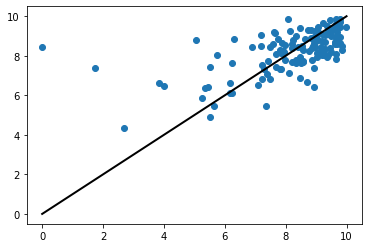

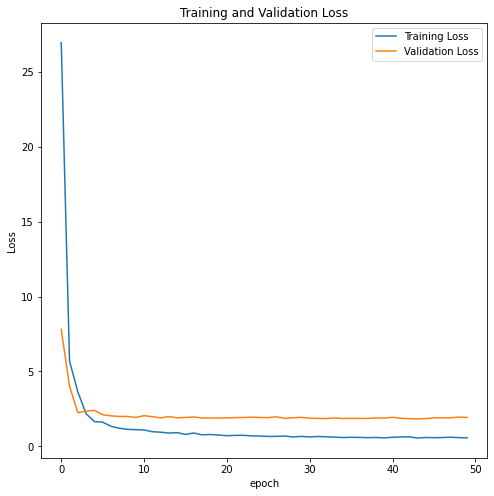

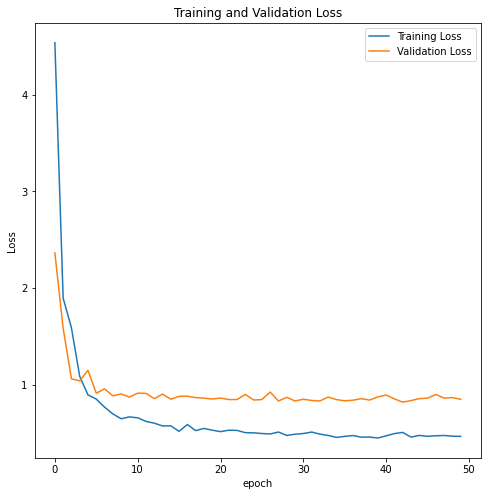

------------------------------------------------------------------------
Training for fold 3, seed 500 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 27.3113 - mean_absolute_error: 4.5864 - val_loss: 5.8815 - val_mean_absolute_error: 2.0935
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.7903 - mean_absolute_error: 1.9393 - val_loss: 3.4634 - val_mean_absolute_error: 1.5334
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.5187 - mean_absolute_error: 1.5653 - val_loss: 2.1565 - val_mean_absolute_error: 1.0681
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0760 - mean_absolute_error: 1.0646 - val_loss: 1.9791 - val_mean_absolute_error: 0.9980
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6044 - mean_absolute_error: 0.8747 - val_loss: 2.1172 - val_mean_absolute_error: 1.1220
Epoch 6/50
568/5

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.5736 - mean_absolute_error: 0.4601 - val_loss: 1.7594 - val_mean_absolute_error: 0.8981
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6077 - mean_absolute_error: 0.4888 - val_loss: 1.7746 - val_mean_absolute_error: 0.9161
Spearman correlation: 0.560


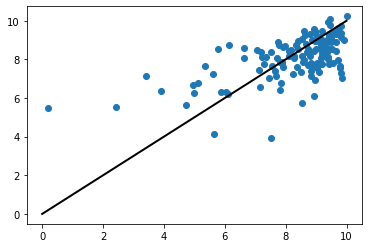

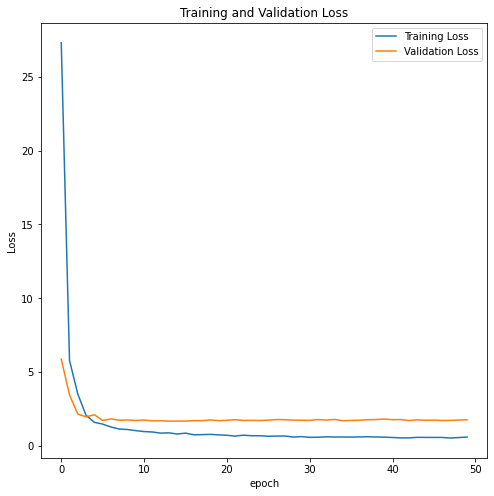

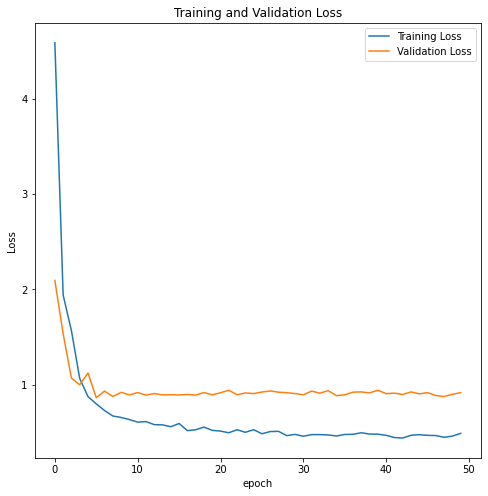

------------------------------------------------------------------------
Training for fold 4, seed 500 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 26.7283 - mean_absolute_error: 4.4529 - val_loss: 5.9513 - val_mean_absolute_error: 2.0717
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.2763 - mean_absolute_error: 1.8058 - val_loss: 3.3121 - val_mean_absolute_error: 1.4751
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3960 - mean_absolute_error: 1.5118 - val_loss: 1.8656 - val_mean_absolute_error: 0.9883
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0922 - mean_absolute_error: 1.0419 - val_loss: 1.8966 - val_mean_absolute_error: 0.9728
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6954 - mean_absolute_error: 0.8912 - val_loss: 1.8177 - val_mean_absolute_error: 0.9849
Epoch 6/50
568/5

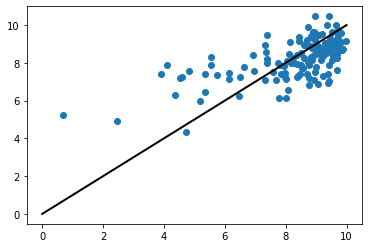

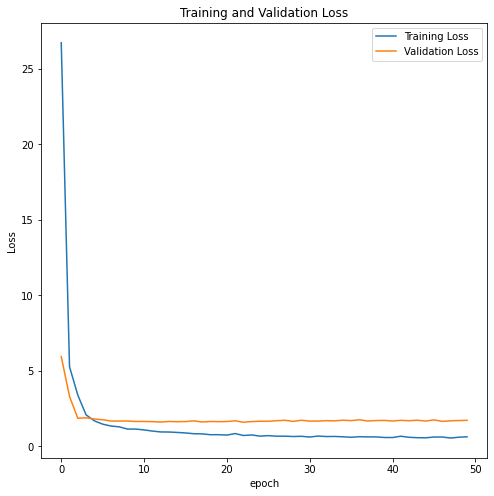

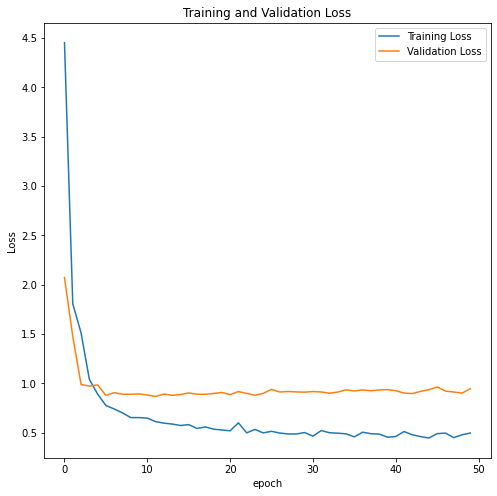

------------------------------------------------------------------------
Training for fold 5, seed 500 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 26.5179 - mean_absolute_error: 4.4779 - val_loss: 6.7099 - val_mean_absolute_error: 2.2338
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.4911 - mean_absolute_error: 1.8899 - val_loss: 3.0513 - val_mean_absolute_error: 1.4034
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.2971 - mean_absolute_error: 1.4948 - val_loss: 2.2496 - val_mean_absolute_error: 1.2023
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9971 - mean_absolute_error: 1.0063 - val_loss: 2.2590 - val_mean_absolute_error: 1.1277
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6749 - mean_absolute_error: 0.8780 - val_loss: 1.9592 - val_mean_absolute_error: 1.0991
Epoch 6/50
568/5

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6132 - mean_absolute_error: 0.4805 - val_loss: 1.6472 - val_mean_absolute_error: 0.9284
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6283 - mean_absolute_error: 0.5035 - val_loss: 1.7053 - val_mean_absolute_error: 0.9198
Spearman correlation: 0.442


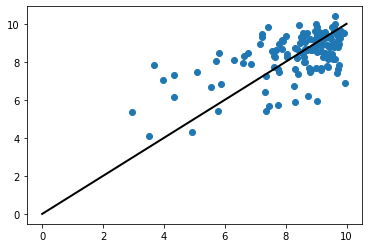

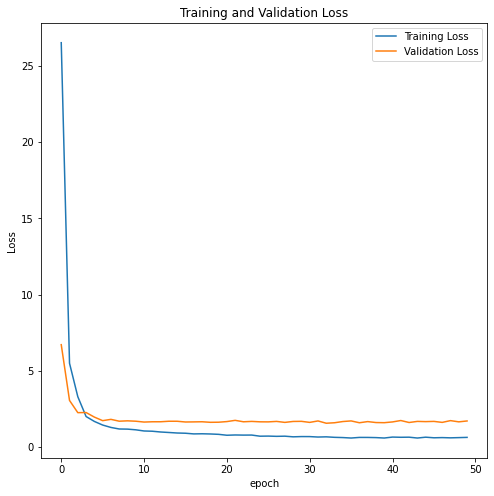

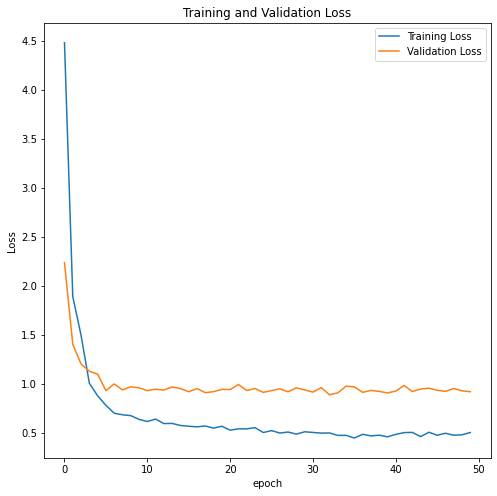

Overall spearman correlation: 0.525
------------------------------------------------------------------------
Training for fold 1, seed 600 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 30.8185 - mean_absolute_error: 4.8804 - val_loss: 5.0061 - val_mean_absolute_error: 1.8222
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.0654 - mean_absolute_error: 1.9307 - val_loss: 2.8717 - val_mean_absolute_error: 1.2882
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.1875 - mean_absolute_error: 1.4373 - val_loss: 2.2749 - val_mean_absolute_error: 1.1624
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.1804 - mean_absolute_error: 1.0513 - val_loss: 2.2620 - val_mean_absolute_error: 1.1083
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7486 - mean_absolute_error: 0.9218 - val_loss: 1.9366 - val_mean_abs

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6440 - mean_absolute_error: 0.4999 - val_loss: 1.5423 - val_mean_absolute_error: 0.8686
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6821 - mean_absolute_error: 0.5219 - val_loss: 1.5444 - val_mean_absolute_error: 0.8704
Spearman correlation: 0.573


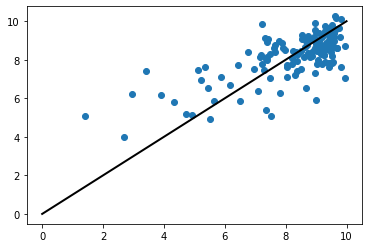

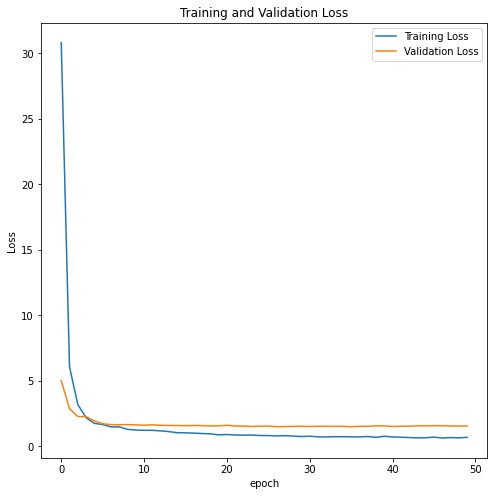

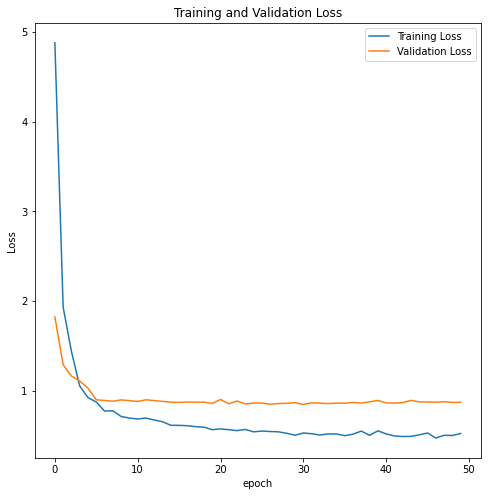

------------------------------------------------------------------------
Training for fold 2, seed 600 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 30.8299 - mean_absolute_error: 4.9096 - val_loss: 6.8701 - val_mean_absolute_error: 2.1826
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.9180 - mean_absolute_error: 1.9165 - val_loss: 2.7787 - val_mean_absolute_error: 1.2889
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.4900 - mean_absolute_error: 1.5037 - val_loss: 2.2908 - val_mean_absolute_error: 1.2334
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0585 - mean_absolute_error: 1.0333 - val_loss: 2.3100 - val_mean_absolute_error: 1.1043
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9698 - mean_absolute_error: 0.9909 - val_loss: 1.7842 - val_mean_absolute_error: 0.9890
Epoch 6/50
568/5

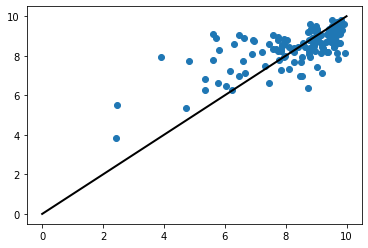

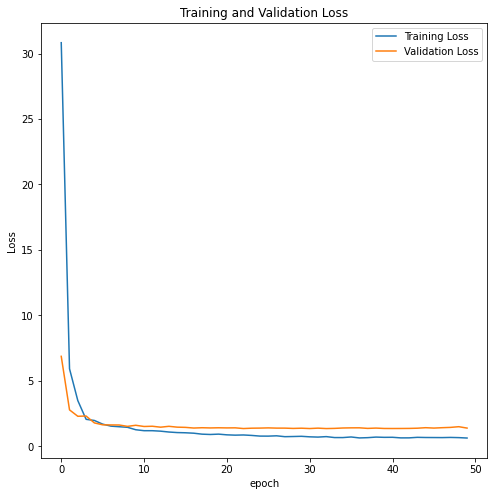

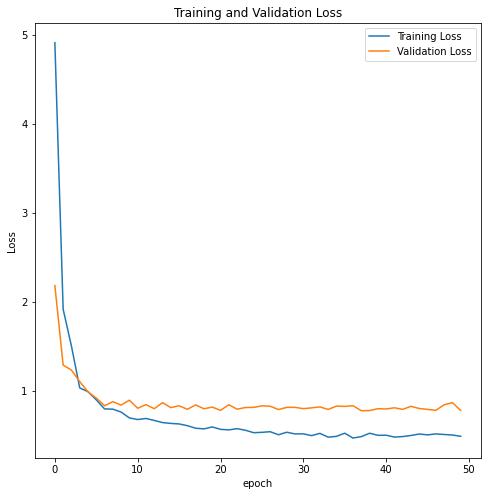

------------------------------------------------------------------------
Training for fold 3, seed 600 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 3ms/sample - loss: 30.9119 - mean_absolute_error: 4.9427 - val_loss: 5.1255 - val_mean_absolute_error: 1.7998
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.3469 - mean_absolute_error: 2.0630 - val_loss: 5.1617 - val_mean_absolute_error: 1.6254
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3592 - mean_absolute_error: 1.5103 - val_loss: 3.8796 - val_mean_absolute_error: 1.5903
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9674 - mean_absolute_error: 1.0276 - val_loss: 3.5218 - val_mean_absolute_error: 1.2881
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7966 - mean_absolute_error: 0.9501 - val_loss: 2.9470 - val_mean_absolute_error: 1.2100
Epoch 6/50
568/5

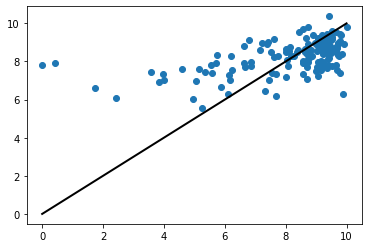

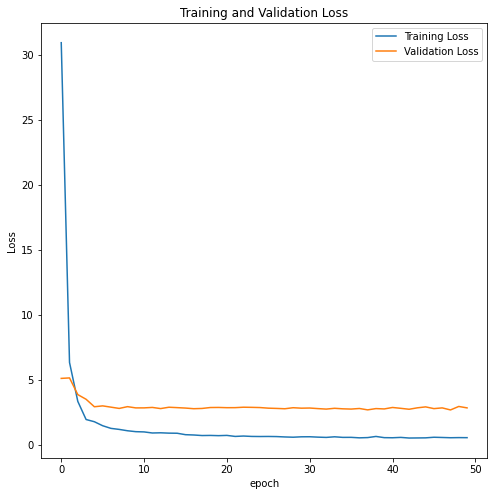

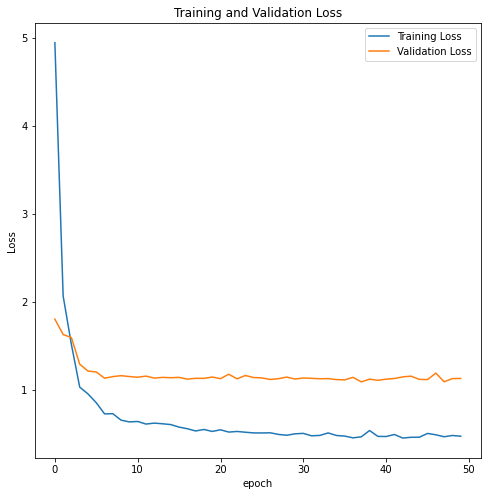

------------------------------------------------------------------------
Training for fold 4, seed 600 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.5985 - mean_absolute_error: 4.9266 - val_loss: 6.5375 - val_mean_absolute_error: 2.1089
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.1995 - mean_absolute_error: 1.9822 - val_loss: 2.5059 - val_mean_absolute_error: 1.0984
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3868 - mean_absolute_error: 1.5075 - val_loss: 2.9057 - val_mean_absolute_error: 1.3578
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0750 - mean_absolute_error: 1.0638 - val_loss: 2.3400 - val_mean_absolute_error: 1.0421
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7258 - mean_absolute_error: 0.9077 - val_loss: 2.2418 - val_mean_absolute_error: 1.1225
Epoch 6/50
568/5

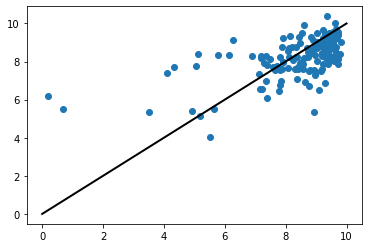

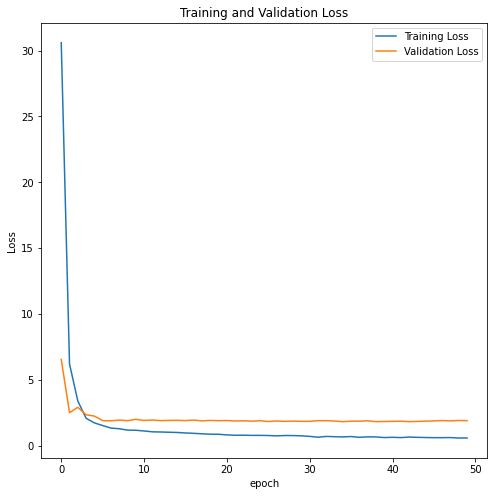

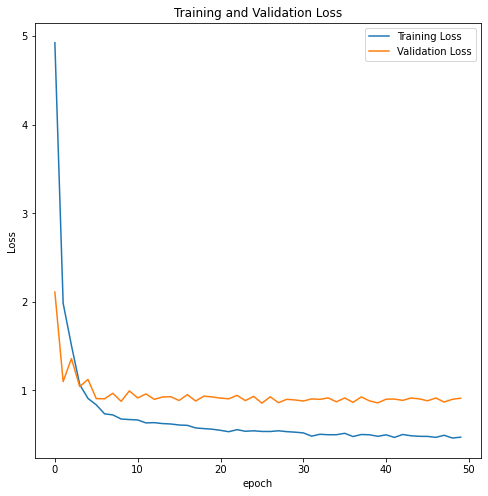

------------------------------------------------------------------------
Training for fold 5, seed 600 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.6134 - mean_absolute_error: 4.9056 - val_loss: 5.6856 - val_mean_absolute_error: 1.8884
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.2432 - mean_absolute_error: 2.0050 - val_loss: 2.7881 - val_mean_absolute_error: 1.3014
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.6719 - mean_absolute_error: 1.5645 - val_loss: 2.7279 - val_mean_absolute_error: 1.3845
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.1752 - mean_absolute_error: 1.0768 - val_loss: 2.0993 - val_mean_absolute_error: 1.1035
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.8779 - mean_absolute_error: 0.9658 - val_loss: 1.9450 - val_mean_absolute_error: 1.0409
Epoch 6/50
568/5

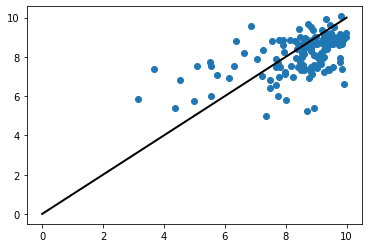

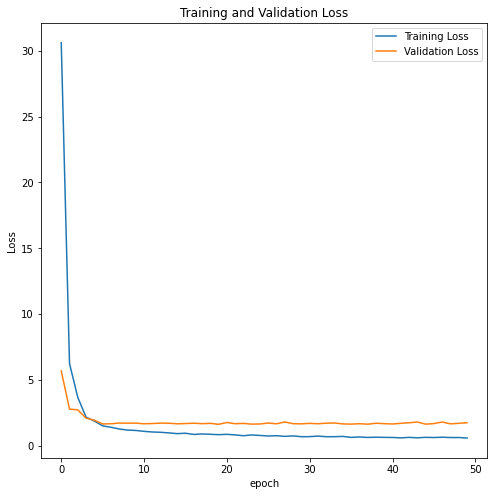

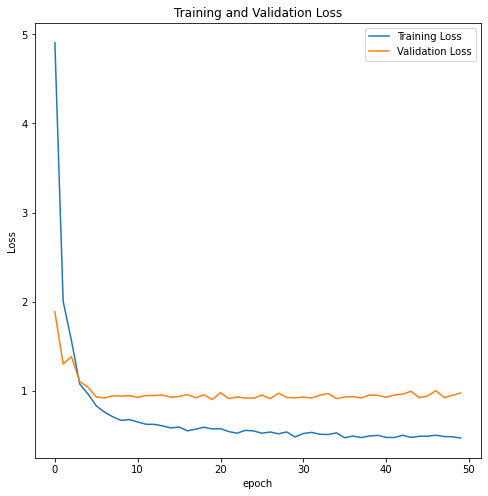

Overall spearman correlation: 0.528
------------------------------------------------------------------------
Training for fold 1, seed 700 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.9590 - mean_absolute_error: 4.9146 - val_loss: 5.0529 - val_mean_absolute_error: 1.8086
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.9927 - mean_absolute_error: 1.9389 - val_loss: 3.0264 - val_mean_absolute_error: 1.3177
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3731 - mean_absolute_error: 1.5013 - val_loss: 3.2940 - val_mean_absolute_error: 1.4904
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0952 - mean_absolute_error: 1.0473 - val_loss: 2.6394 - val_mean_absolute_error: 1.1961
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7806 - mean_absolute_error: 0.9123 - val_loss: 2.2898 - val_mean_abs

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6391 - mean_absolute_error: 0.4989 - val_loss: 2.0308 - val_mean_absolute_error: 1.0267
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6777 - mean_absolute_error: 0.5145 - val_loss: 2.0698 - val_mean_absolute_error: 1.0238
Spearman correlation: 0.421


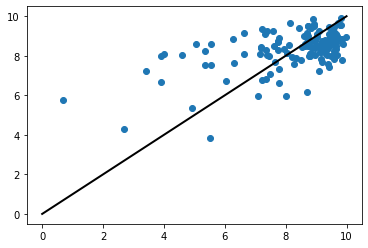

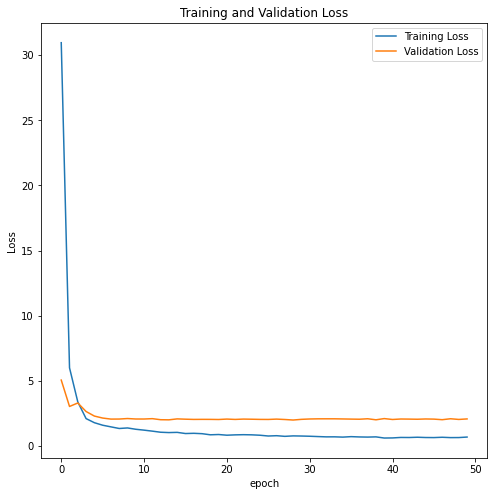

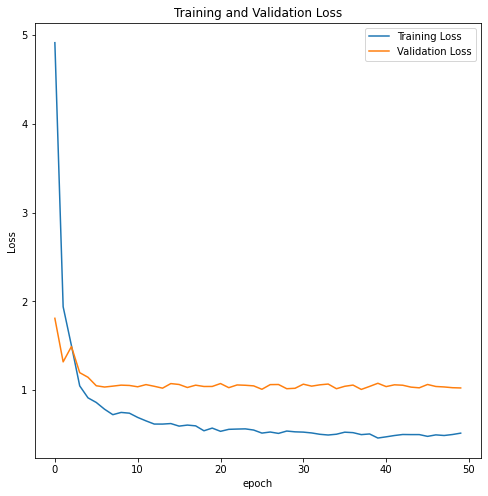

------------------------------------------------------------------------
Training for fold 2, seed 700 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 31.1980 - mean_absolute_error: 4.9648 - val_loss: 4.9117 - val_mean_absolute_error: 1.7581
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.6456 - mean_absolute_error: 1.9010 - val_loss: 3.4552 - val_mean_absolute_error: 1.3421
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.1885 - mean_absolute_error: 1.4496 - val_loss: 2.8664 - val_mean_absolute_error: 1.3082
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9704 - mean_absolute_error: 1.0324 - val_loss: 2.6664 - val_mean_absolute_error: 1.1248
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.5998 - mean_absolute_error: 0.8697 - val_loss: 2.3456 - val_mean_absolute_error: 1.0813
Epoch 6/50
568/5

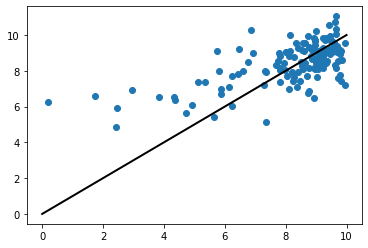

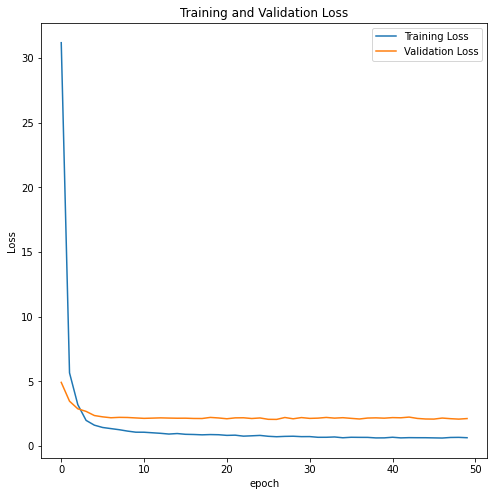

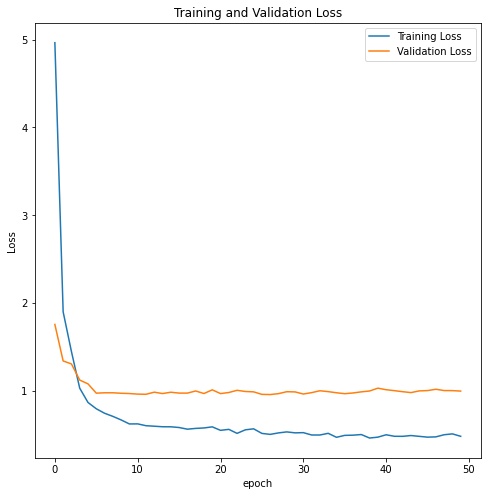

------------------------------------------------------------------------
Training for fold 3, seed 700 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.3487 - mean_absolute_error: 4.8654 - val_loss: 5.7280 - val_mean_absolute_error: 1.9501
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.8595 - mean_absolute_error: 1.9285 - val_loss: 2.5091 - val_mean_absolute_error: 1.1730
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3748 - mean_absolute_error: 1.4944 - val_loss: 2.8431 - val_mean_absolute_error: 1.3720
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0483 - mean_absolute_error: 1.0438 - val_loss: 2.5216 - val_mean_absolute_error: 1.1125
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7108 - mean_absolute_error: 0.9089 - val_loss: 2.2764 - val_mean_absolute_error: 1.1002
Epoch 6/50
568/5

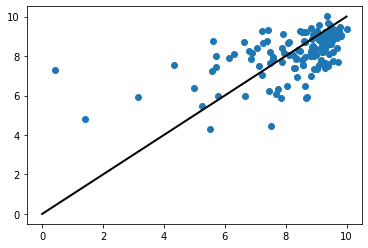

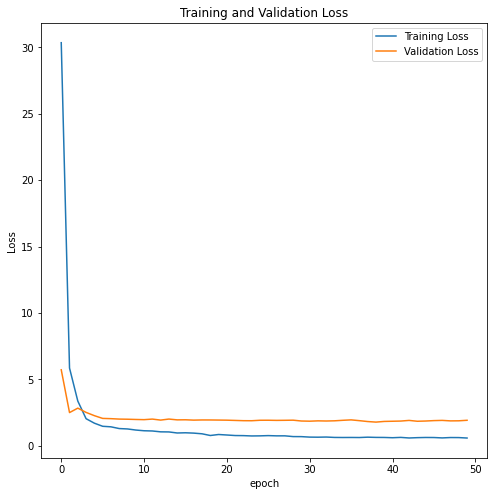

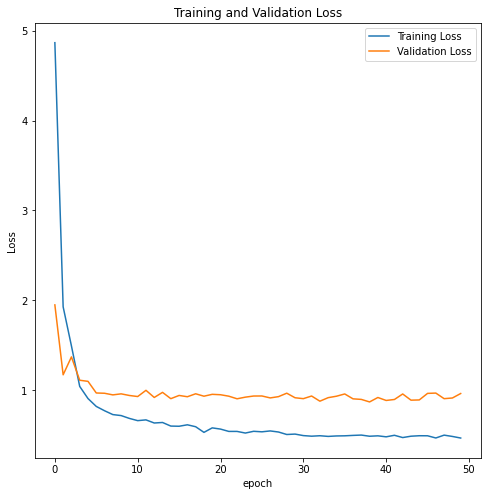

------------------------------------------------------------------------
Training for fold 4, seed 700 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.8740 - mean_absolute_error: 4.9551 - val_loss: 6.8142 - val_mean_absolute_error: 2.2228
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.0553 - mean_absolute_error: 1.9727 - val_loss: 2.9125 - val_mean_absolute_error: 1.2998
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.6848 - mean_absolute_error: 1.5758 - val_loss: 2.4562 - val_mean_absolute_error: 1.2776
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.2237 - mean_absolute_error: 1.0669 - val_loss: 2.2417 - val_mean_absolute_error: 1.1259
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0160 - mean_absolute_error: 1.0008 - val_loss: 1.7457 - val_mean_absolute_error: 0.9624
Epoch 6/50
568/5

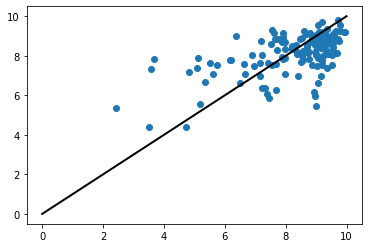

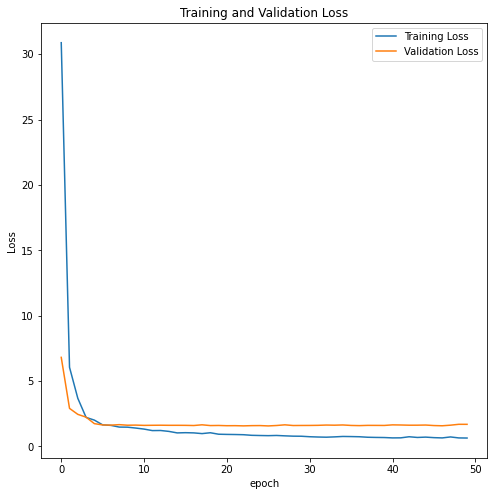

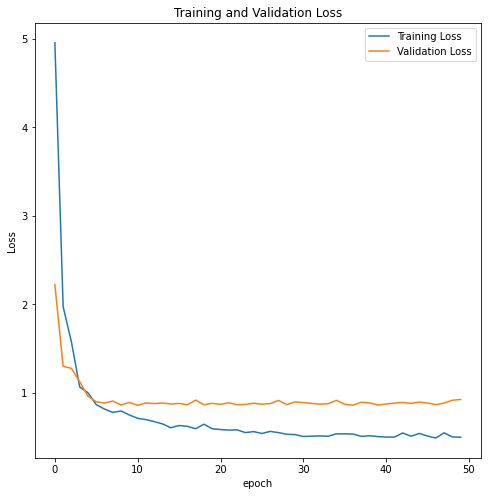

------------------------------------------------------------------------
Training for fold 5, seed 700 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.8752 - mean_absolute_error: 4.9230 - val_loss: 6.1300 - val_mean_absolute_error: 1.9712
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.7425 - mean_absolute_error: 1.9271 - val_loss: 3.4354 - val_mean_absolute_error: 1.3693
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.2480 - mean_absolute_error: 1.4641 - val_loss: 3.1681 - val_mean_absolute_error: 1.4086
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0483 - mean_absolute_error: 1.0434 - val_loss: 2.3403 - val_mean_absolute_error: 1.0808
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6855 - mean_absolute_error: 0.8847 - val_loss: 2.2714 - val_mean_absolute_error: 1.0403
Epoch 6/50
568/5

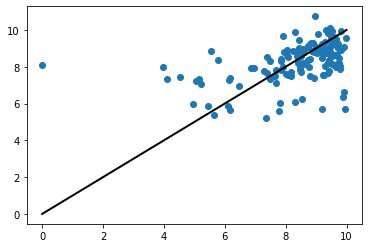

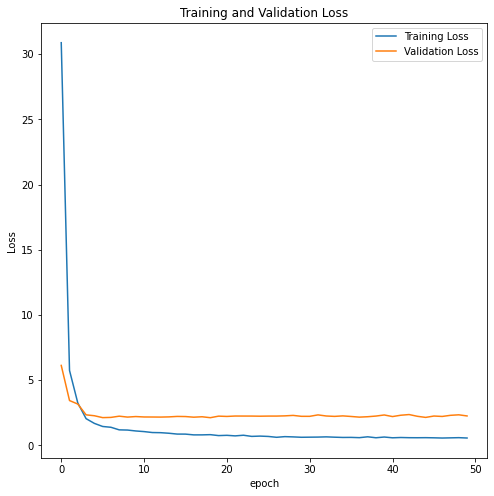

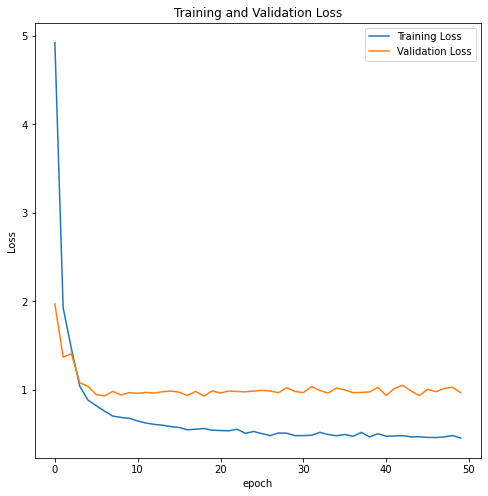

Overall spearman correlation: 0.495
------------------------------------------------------------------------
Training for fold 1, seed 800 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 35.4170 - mean_absolute_error: 5.4648 - val_loss: 4.8073 - val_mean_absolute_error: 1.6194
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.1562 - mean_absolute_error: 2.0076 - val_loss: 2.7054 - val_mean_absolute_error: 1.1445
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.2141 - mean_absolute_error: 1.3982 - val_loss: 3.2053 - val_mean_absolute_error: 1.5236
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.2015 - mean_absolute_error: 1.0963 - val_loss: 2.2573 - val_mean_absolute_error: 1.1224
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9849 - mean_absolute_error: 0.9821 - val_loss: 1.8988 - val_mean_abs

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6096 - mean_absolute_error: 0.4847 - val_loss: 1.9441 - val_mean_absolute_error: 1.0171
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6501 - mean_absolute_error: 0.5143 - val_loss: 1.9686 - val_mean_absolute_error: 1.0079
Spearman correlation: 0.409


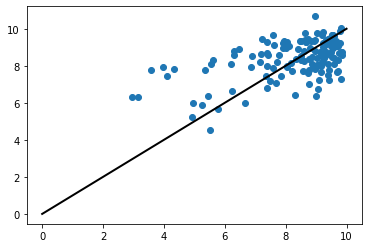

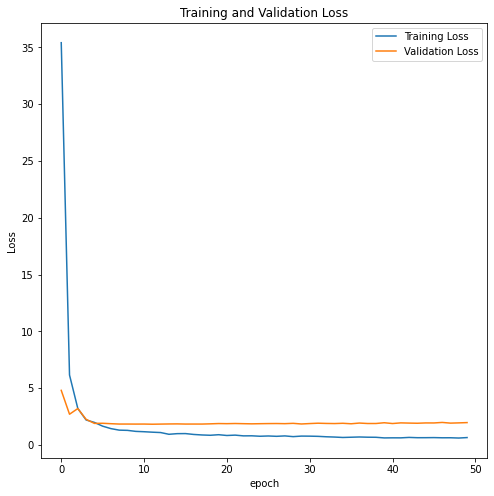

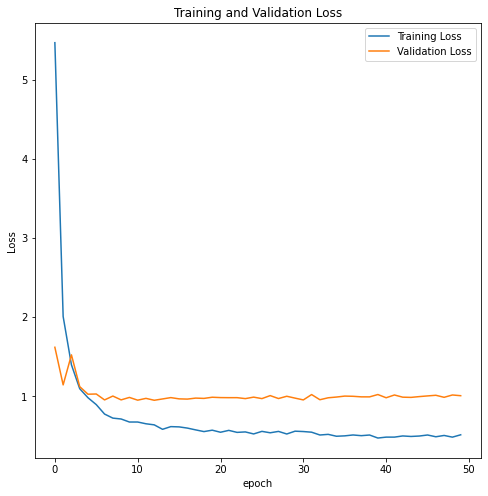

------------------------------------------------------------------------
Training for fold 2, seed 800 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 34.2530 - mean_absolute_error: 5.2798 - val_loss: 5.7688 - val_mean_absolute_error: 1.7295
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.2342 - mean_absolute_error: 2.0021 - val_loss: 2.6999 - val_mean_absolute_error: 1.1483
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3651 - mean_absolute_error: 1.4792 - val_loss: 2.8370 - val_mean_absolute_error: 1.3981
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.2087 - mean_absolute_error: 1.0991 - val_loss: 2.1331 - val_mean_absolute_error: 1.0453
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.8623 - mean_absolute_error: 0.9426 - val_loss: 1.8823 - val_mean_absolute_error: 0.9479
Epoch 6/50
568/5

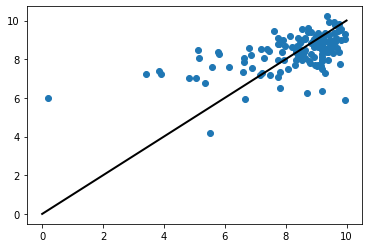

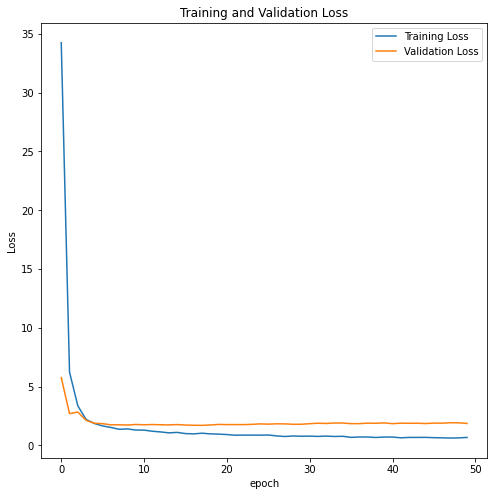

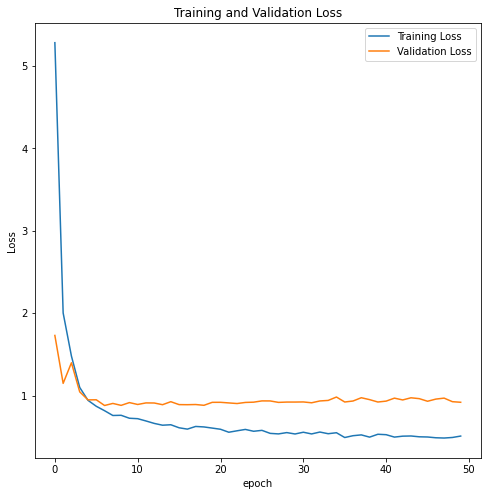

------------------------------------------------------------------------
Training for fold 3, seed 800 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 34.3108 - mean_absolute_error: 5.2972 - val_loss: 7.1461 - val_mean_absolute_error: 1.9908
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.3987 - mean_absolute_error: 2.0538 - val_loss: 2.9321 - val_mean_absolute_error: 1.2669
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.2148 - mean_absolute_error: 1.4108 - val_loss: 2.7309 - val_mean_absolute_error: 1.3519
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0448 - mean_absolute_error: 1.0102 - val_loss: 2.2281 - val_mean_absolute_error: 1.0343
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.8821 - mean_absolute_error: 0.9595 - val_loss: 2.0176 - val_mean_absolute_error: 1.0324
Epoch 6/50
568/5

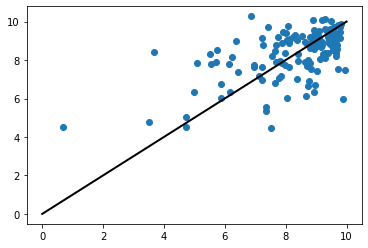

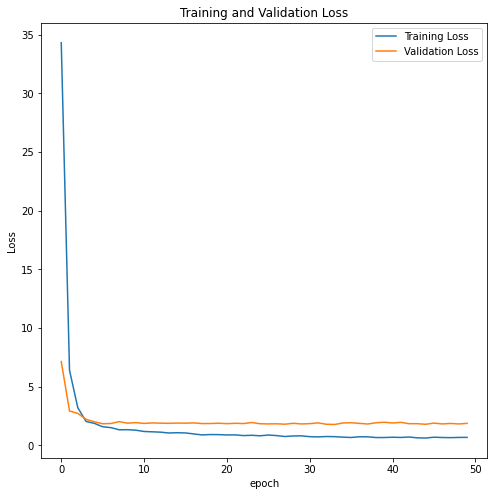

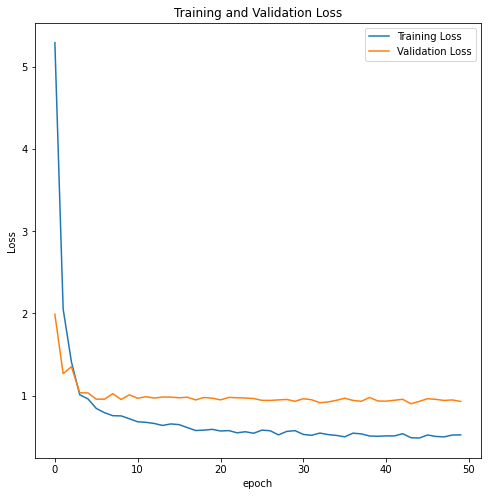

------------------------------------------------------------------------
Training for fold 4, seed 800 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 34.8297 - mean_absolute_error: 5.3916 - val_loss: 6.8831 - val_mean_absolute_error: 1.9523
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.3836 - mean_absolute_error: 2.0627 - val_loss: 3.4419 - val_mean_absolute_error: 1.3222
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.1411 - mean_absolute_error: 1.3976 - val_loss: 3.1815 - val_mean_absolute_error: 1.4695
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9656 - mean_absolute_error: 1.0296 - val_loss: 2.6321 - val_mean_absolute_error: 1.1433
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9284 - mean_absolute_error: 0.9933 - val_loss: 2.2999 - val_mean_absolute_error: 1.0632
Epoch 6/50
568/5

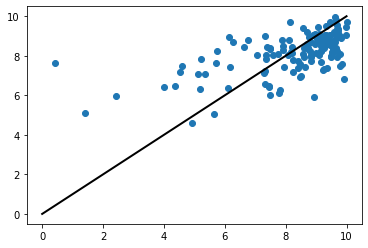

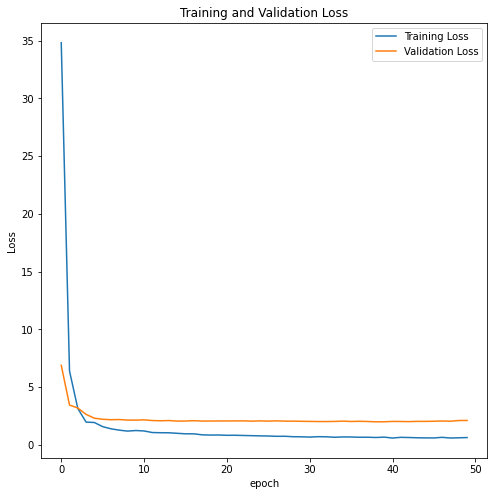

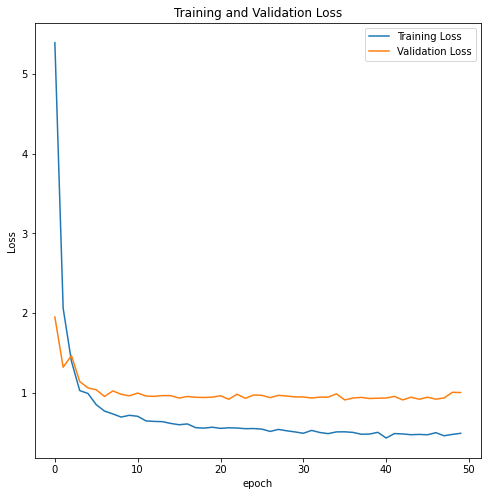

------------------------------------------------------------------------
Training for fold 5, seed 800 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 35.2342 - mean_absolute_error: 5.4222 - val_loss: 5.1513 - val_mean_absolute_error: 1.6625
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.1988 - mean_absolute_error: 2.0207 - val_loss: 3.8164 - val_mean_absolute_error: 1.3308
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.2658 - mean_absolute_error: 1.4478 - val_loss: 3.4137 - val_mean_absolute_error: 1.5121
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.1230 - mean_absolute_error: 1.0624 - val_loss: 2.2693 - val_mean_absolute_error: 0.9930
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7751 - mean_absolute_error: 0.9247 - val_loss: 2.1535 - val_mean_absolute_error: 0.9434
Epoch 6/50
568/5

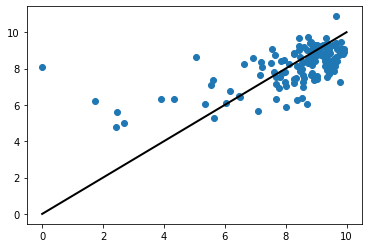

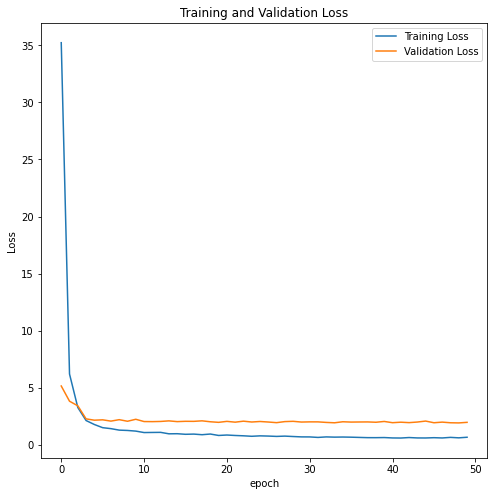

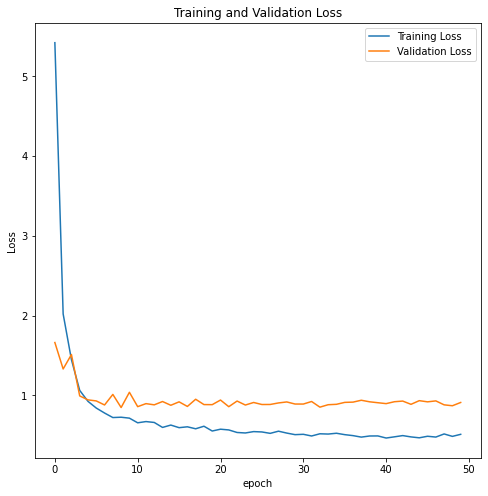

Overall spearman correlation: 0.496
------------------------------------------------------------------------
Training for fold 1, seed 900 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.5577 - mean_absolute_error: 4.9123 - val_loss: 4.4376 - val_mean_absolute_error: 1.7126
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.9698 - mean_absolute_error: 1.9273 - val_loss: 3.6633 - val_mean_absolute_error: 1.4472
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.1200 - mean_absolute_error: 1.4416 - val_loss: 2.7349 - val_mean_absolute_error: 1.3170
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0464 - mean_absolute_error: 1.0364 - val_loss: 2.3764 - val_mean_absolute_error: 1.0685
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7283 - mean_absolute_error: 0.9093 - val_loss: 2.3665 - val_mean_abs

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.5726 - mean_absolute_error: 0.4680 - val_loss: 1.9345 - val_mean_absolute_error: 0.9116
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6009 - mean_absolute_error: 0.4827 - val_loss: 1.9777 - val_mean_absolute_error: 0.9535
Spearman correlation: 0.551


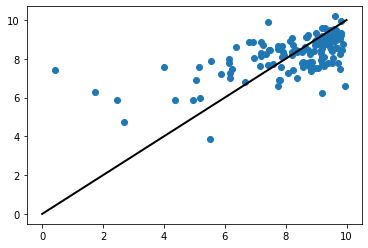

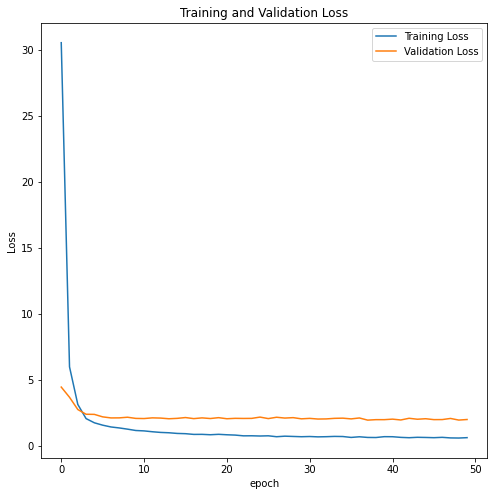

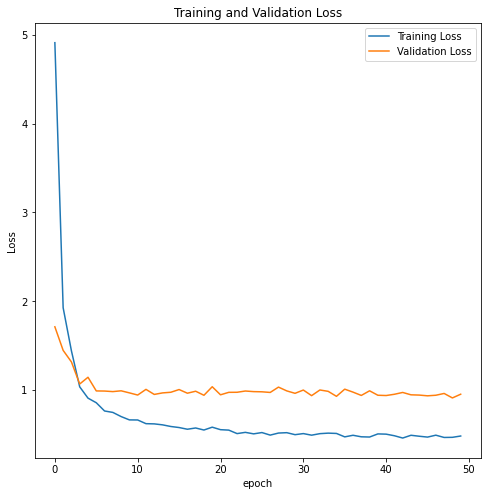

------------------------------------------------------------------------
Training for fold 2, seed 900 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.1105 - mean_absolute_error: 4.8133 - val_loss: 5.1426 - val_mean_absolute_error: 1.8804
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.8786 - mean_absolute_error: 1.9338 - val_loss: 2.7840 - val_mean_absolute_error: 1.2866
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.4117 - mean_absolute_error: 1.4993 - val_loss: 2.1399 - val_mean_absolute_error: 1.1571
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.1631 - mean_absolute_error: 1.0531 - val_loss: 2.0863 - val_mean_absolute_error: 1.0393
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7354 - mean_absolute_error: 0.8849 - val_loss: 1.8522 - val_mean_absolute_error: 1.0184
Epoch 6/50
568/5

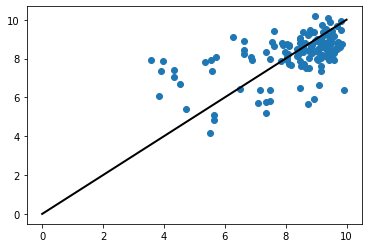

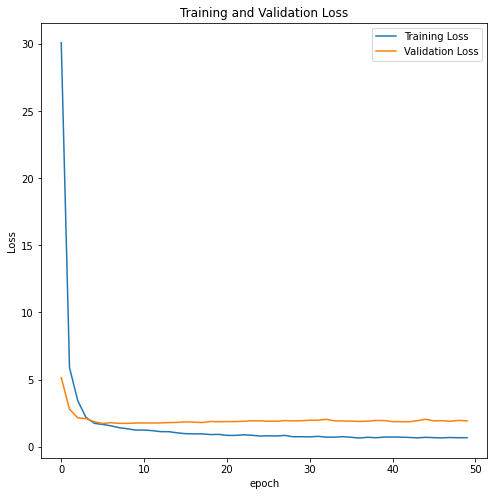

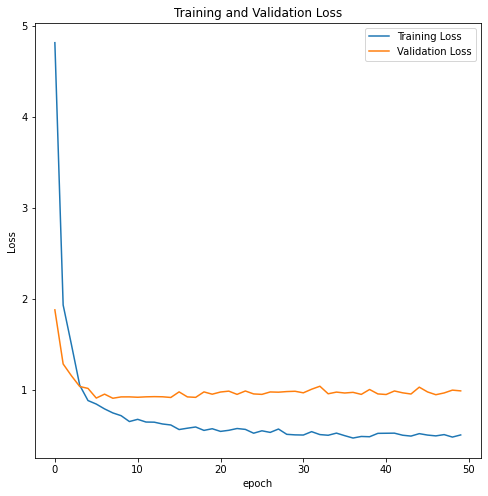

------------------------------------------------------------------------
Training for fold 3, seed 900 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.2524 - mean_absolute_error: 4.8331 - val_loss: 5.4493 - val_mean_absolute_error: 1.8998
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.7055 - mean_absolute_error: 1.9044 - val_loss: 3.0272 - val_mean_absolute_error: 1.4035
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.4081 - mean_absolute_error: 1.4846 - val_loss: 2.4273 - val_mean_absolute_error: 1.2508
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.1630 - mean_absolute_error: 1.0433 - val_loss: 2.0363 - val_mean_absolute_error: 1.0211
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7510 - mean_absolute_error: 0.9065 - val_loss: 2.0156 - val_mean_absolute_error: 1.0710
Epoch 6/50
568/5

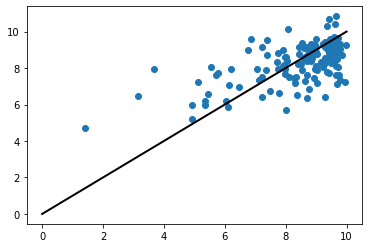

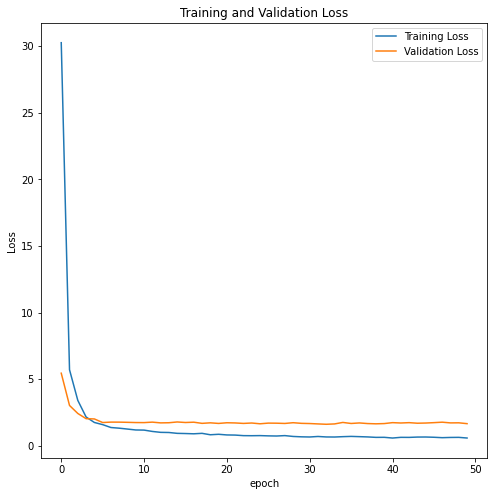

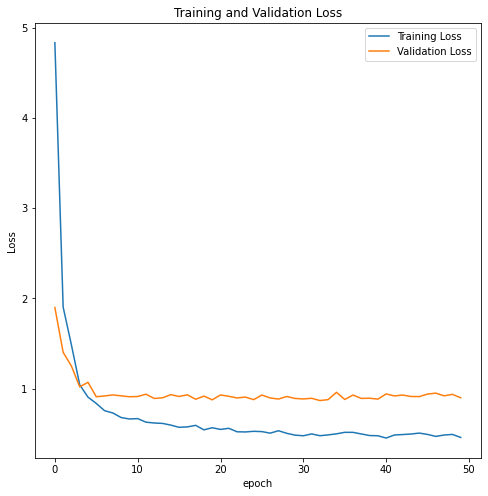

------------------------------------------------------------------------
Training for fold 4, seed 900 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.9707 - mean_absolute_error: 4.9569 - val_loss: 6.5302 - val_mean_absolute_error: 2.1867
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.0354 - mean_absolute_error: 1.9714 - val_loss: 3.5376 - val_mean_absolute_error: 1.2999
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3262 - mean_absolute_error: 1.4781 - val_loss: 2.7544 - val_mean_absolute_error: 1.3017
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0556 - mean_absolute_error: 1.0632 - val_loss: 2.7112 - val_mean_absolute_error: 1.1977
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7284 - mean_absolute_error: 0.9354 - val_loss: 2.3290 - val_mean_absolute_error: 1.0670
Epoch 6/50
568/5

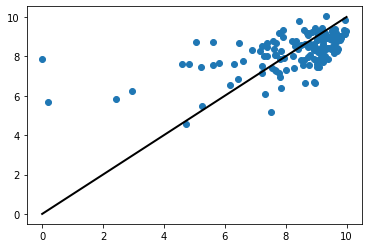

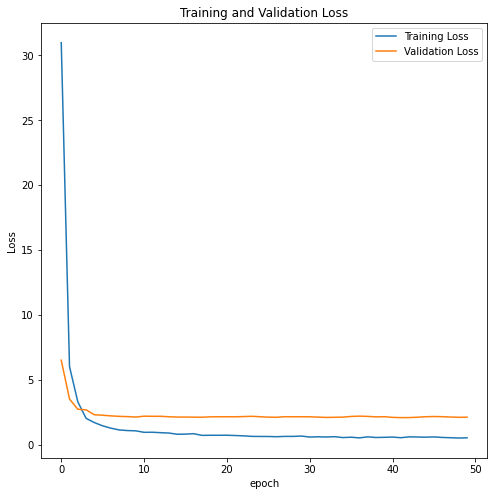

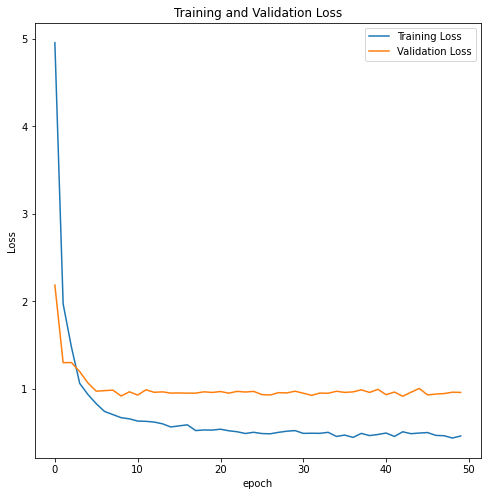

------------------------------------------------------------------------
Training for fold 5, seed 900 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.1658 - mean_absolute_error: 4.8419 - val_loss: 7.2363 - val_mean_absolute_error: 2.2693
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.5939 - mean_absolute_error: 1.9009 - val_loss: 2.6962 - val_mean_absolute_error: 1.2274
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.1637 - mean_absolute_error: 1.4049 - val_loss: 2.4221 - val_mean_absolute_error: 1.1987
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0778 - mean_absolute_error: 1.0182 - val_loss: 2.2296 - val_mean_absolute_error: 1.0814
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.5566 - mean_absolute_error: 0.8352 - val_loss: 2.1139 - val_mean_absolute_error: 1.0764
Epoch 6/50
568/5

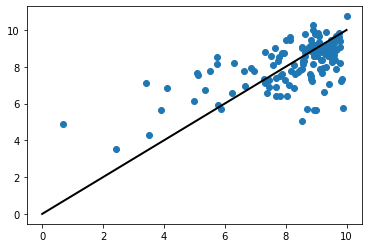

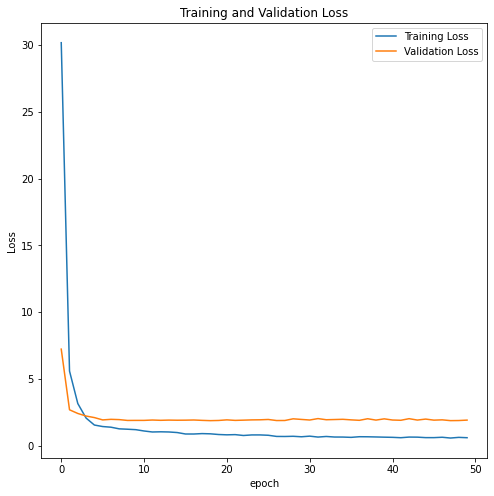

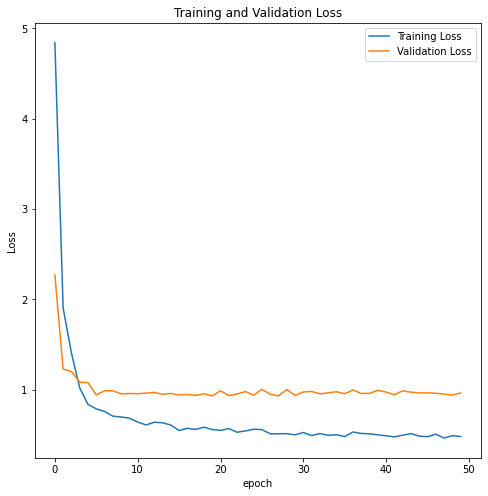

Overall spearman correlation: 0.521
------------------------------------------------------------------------
Training for fold 1, seed 1000 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.3104 - mean_absolute_error: 4.8461 - val_loss: 5.9230 - val_mean_absolute_error: 2.0565
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.3103 - mean_absolute_error: 2.0162 - val_loss: 2.5262 - val_mean_absolute_error: 1.2237
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.3823 - mean_absolute_error: 1.5040 - val_loss: 2.1403 - val_mean_absolute_error: 1.1680
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.2015 - mean_absolute_error: 1.0571 - val_loss: 2.0226 - val_mean_absolute_error: 0.9742
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.8689 - mean_absolute_error: 0.9332 - val_loss: 2.0499 - val_mean_ab

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6925 - mean_absolute_error: 0.5307 - val_loss: 1.7156 - val_mean_absolute_error: 0.8526
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6048 - mean_absolute_error: 0.4759 - val_loss: 1.6845 - val_mean_absolute_error: 0.8450
Spearman correlation: 0.643


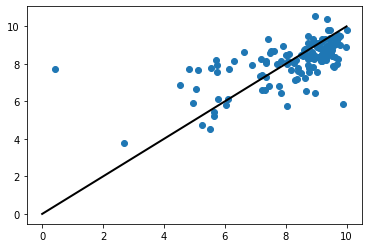

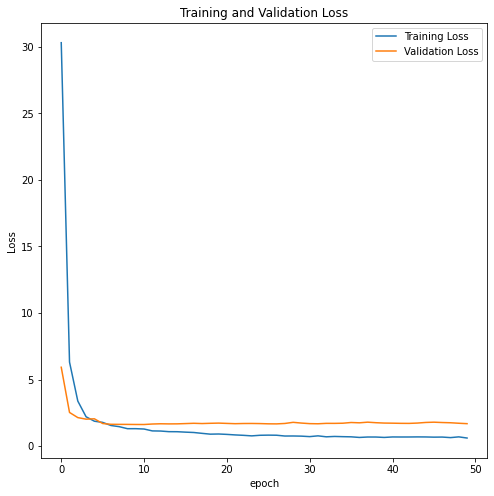

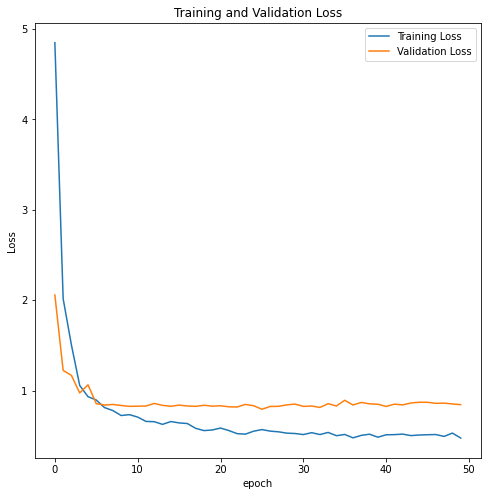

------------------------------------------------------------------------
Training for fold 2, seed 1000 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.3474 - mean_absolute_error: 4.8771 - val_loss: 6.7264 - val_mean_absolute_error: 2.0726
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.6487 - mean_absolute_error: 1.8491 - val_loss: 3.9901 - val_mean_absolute_error: 1.3490
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.8961 - mean_absolute_error: 1.3785 - val_loss: 3.2625 - val_mean_absolute_error: 1.3474
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9877 - mean_absolute_error: 1.0486 - val_loss: 3.3313 - val_mean_absolute_error: 1.2928
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.4621 - mean_absolute_error: 0.8384 - val_loss: 2.9432 - val_mean_absolute_error: 1.2153
Epoch 6/50
568/

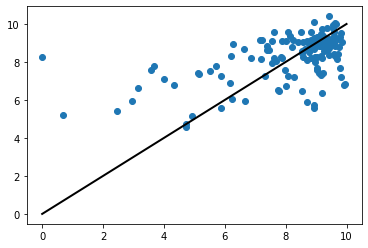

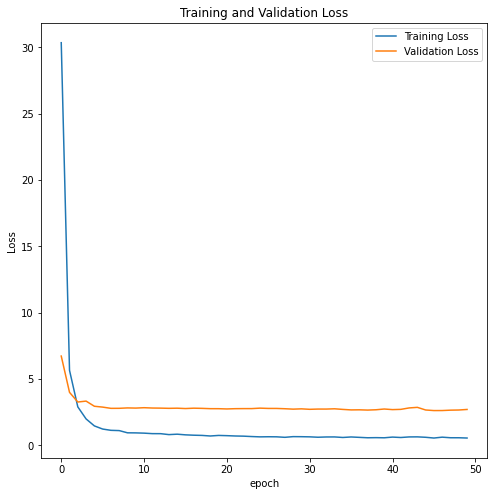

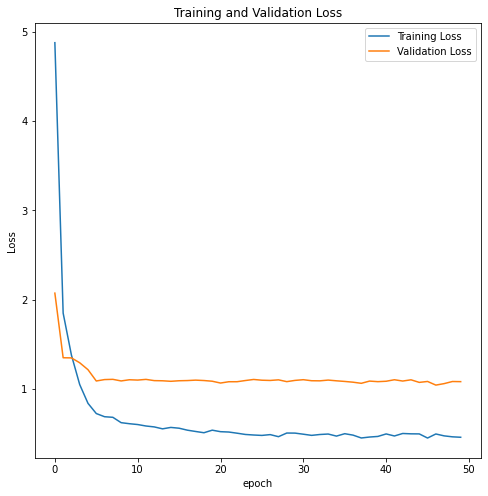

------------------------------------------------------------------------
Training for fold 3, seed 1000 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 29.9443 - mean_absolute_error: 4.8641 - val_loss: 5.5026 - val_mean_absolute_error: 1.9193
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.8625 - mean_absolute_error: 1.9302 - val_loss: 2.5964 - val_mean_absolute_error: 1.1632
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.1993 - mean_absolute_error: 1.4358 - val_loss: 2.6176 - val_mean_absolute_error: 1.3047
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9041 - mean_absolute_error: 0.9690 - val_loss: 2.1902 - val_mean_absolute_error: 1.0593
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7709 - mean_absolute_error: 0.9029 - val_loss: 1.8789 - val_mean_absolute_error: 1.0181
Epoch 6/50
568/

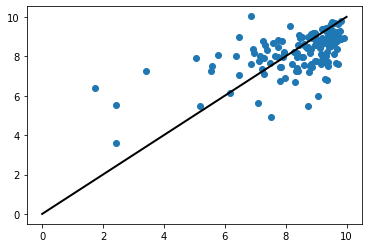

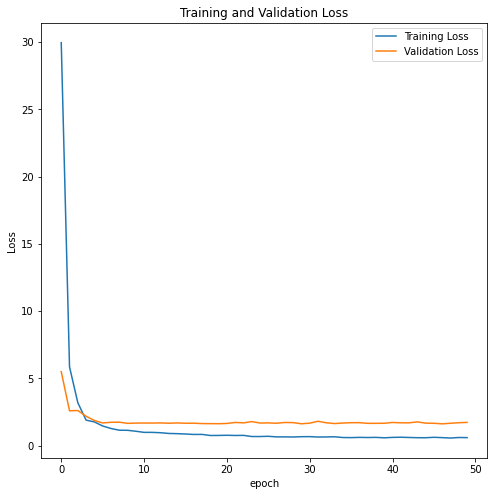

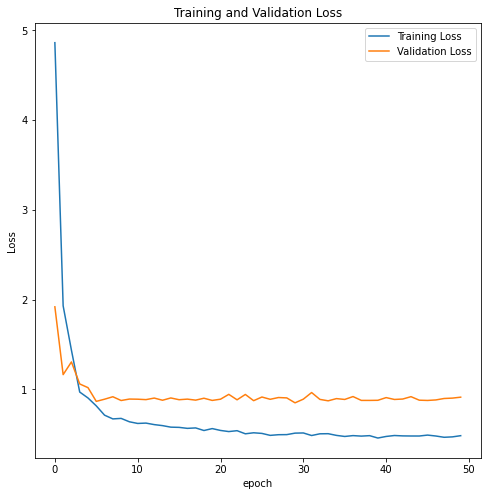

------------------------------------------------------------------------
Training for fold 4, seed 1000 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 31.0812 - mean_absolute_error: 4.9725 - val_loss: 5.1685 - val_mean_absolute_error: 1.8505
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.8748 - mean_absolute_error: 1.9428 - val_loss: 2.6339 - val_mean_absolute_error: 1.1943
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.0914 - mean_absolute_error: 1.4234 - val_loss: 2.6211 - val_mean_absolute_error: 1.3163
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0891 - mean_absolute_error: 1.0534 - val_loss: 2.0874 - val_mean_absolute_error: 1.0175
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.5423 - mean_absolute_error: 0.8241 - val_loss: 1.9799 - val_mean_absolute_error: 1.0691
Epoch 6/50
568/

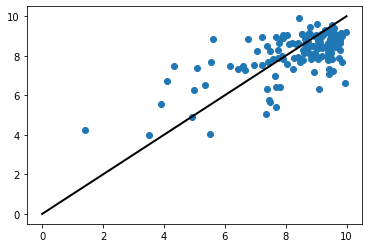

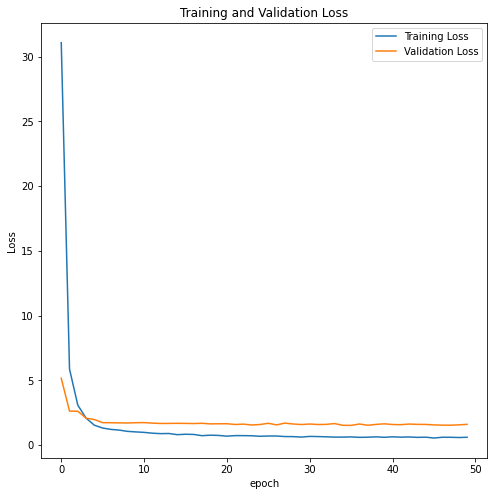

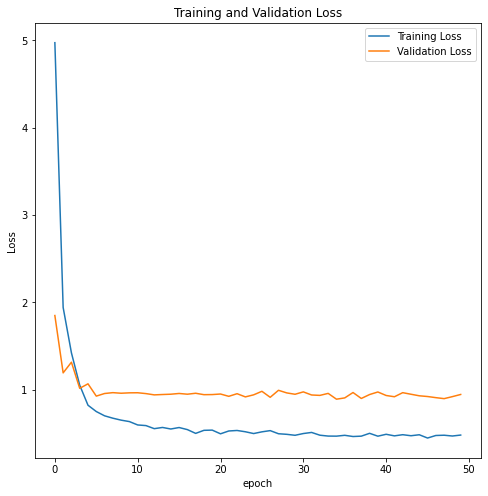

------------------------------------------------------------------------
Training for fold 5, seed 1000 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 30.5061 - mean_absolute_error: 4.9386 - val_loss: 3.9085 - val_mean_absolute_error: 1.5996
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.8232 - mean_absolute_error: 1.9272 - val_loss: 2.8393 - val_mean_absolute_error: 1.2084
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.0087 - mean_absolute_error: 1.3959 - val_loss: 2.3263 - val_mean_absolute_error: 1.1806
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.8378 - mean_absolute_error: 0.9745 - val_loss: 1.9545 - val_mean_absolute_error: 1.0160
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.5359 - mean_absolute_error: 0.8252 - val_loss: 1.8249 - val_mean_absolute_error: 1.0050
Epoch 6/50
568/

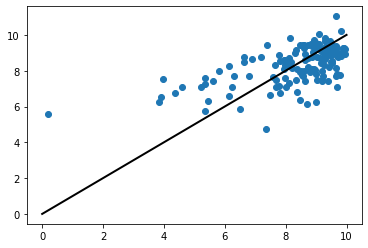

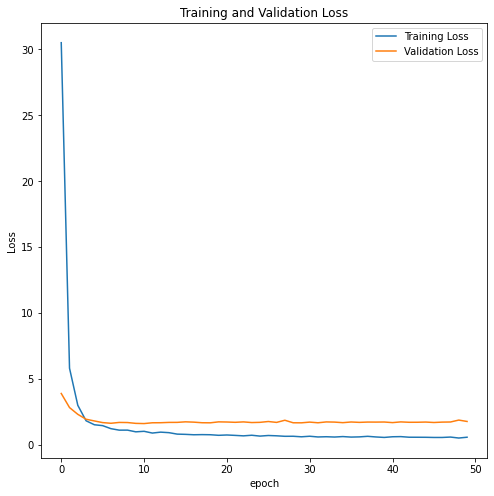

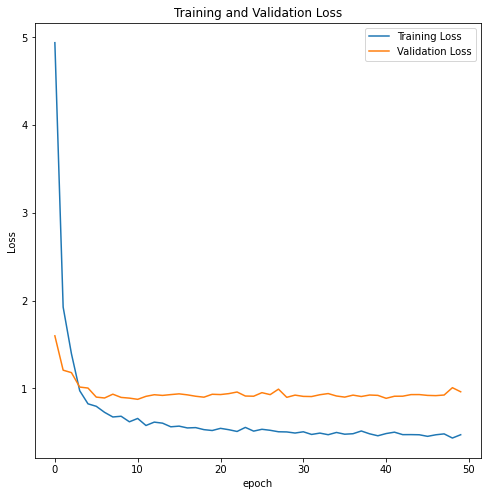

Overall spearman correlation: 0.514
------------------------------------------------------------------------
Training for fold 1, seed 1100 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 2s 4ms/sample - loss: 29.3183 - mean_absolute_error: 4.7589 - val_loss: 7.6628 - val_mean_absolute_error: 2.3453
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.0241 - mean_absolute_error: 1.9735 - val_loss: 2.8875 - val_mean_absolute_error: 1.2757
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.7305 - mean_absolute_error: 1.5979 - val_loss: 2.5754 - val_mean_absolute_error: 1.2440
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.1770 - mean_absolute_error: 1.0455 - val_loss: 2.5751 - val_mean_absolute_error: 1.1461
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6760 - mean_absolute_error: 0.8898 - val_loss: 2.3965 - val_mean_ab

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.5936 - mean_absolute_error: 0.4790 - val_loss: 2.1605 - val_mean_absolute_error: 0.9633
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6316 - mean_absolute_error: 0.5010 - val_loss: 2.1970 - val_mean_absolute_error: 0.9825
Spearman correlation: 0.468


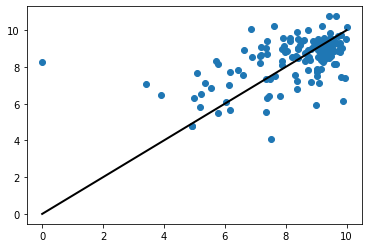

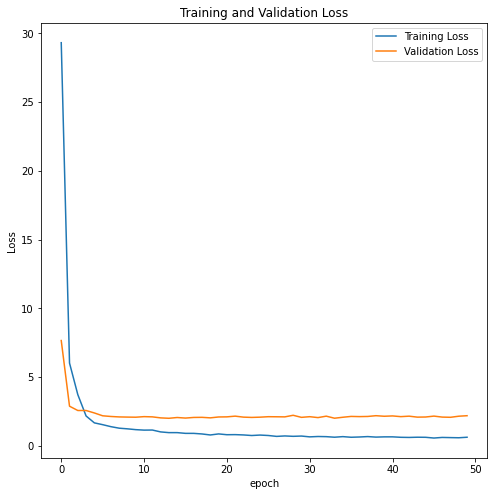

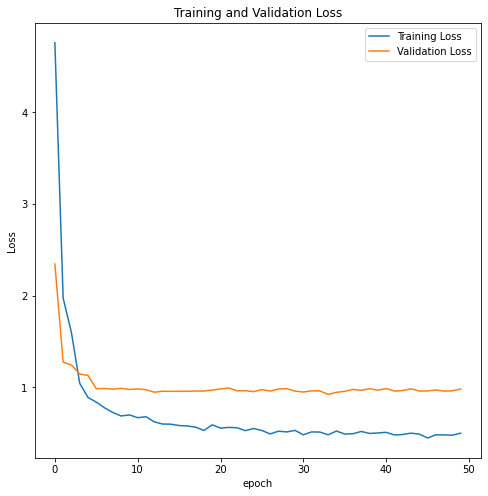

------------------------------------------------------------------------
Training for fold 2, seed 1100 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 3s 4ms/sample - loss: 30.4329 - mean_absolute_error: 4.8516 - val_loss: 4.9238 - val_mean_absolute_error: 1.7922
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.1344 - mean_absolute_error: 1.9861 - val_loss: 4.4132 - val_mean_absolute_error: 1.5588
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.0050 - mean_absolute_error: 1.4143 - val_loss: 3.2005 - val_mean_absolute_error: 1.4086
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9398 - mean_absolute_error: 1.0308 - val_loss: 2.9269 - val_mean_absolute_error: 1.1716
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.5768 - mean_absolute_error: 0.8697 - val_loss: 2.8284 - val_mean_absolute_error: 1.2010
Epoch 6/50
568/

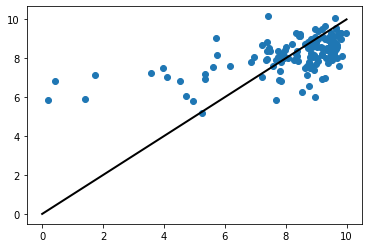

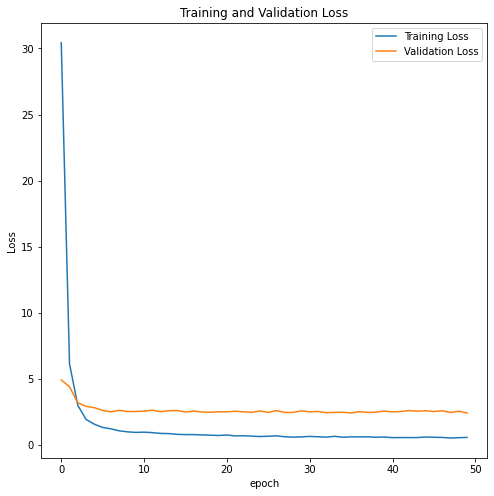

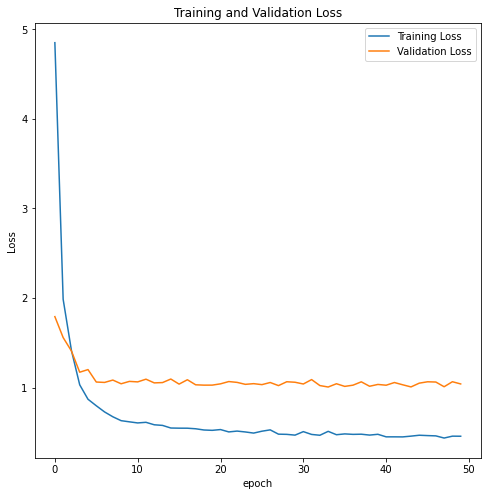

------------------------------------------------------------------------
Training for fold 3, seed 1100 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 3s 5ms/sample - loss: 29.1455 - mean_absolute_error: 4.7351 - val_loss: 4.8670 - val_mean_absolute_error: 1.8406
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 6.4134 - mean_absolute_error: 2.0353 - val_loss: 2.6537 - val_mean_absolute_error: 1.3377
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.6639 - mean_absolute_error: 1.5917 - val_loss: 2.3063 - val_mean_absolute_error: 1.2356
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.2588 - mean_absolute_error: 1.0887 - val_loss: 1.7731 - val_mean_absolute_error: 0.9929
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.7989 - mean_absolute_error: 0.9112 - val_loss: 1.6978 - val_mean_absolute_error: 1.0025
Epoch 6/50
568/

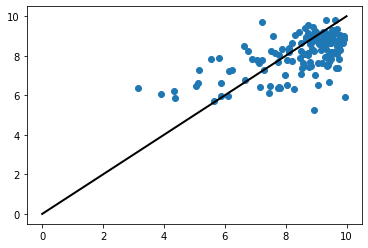

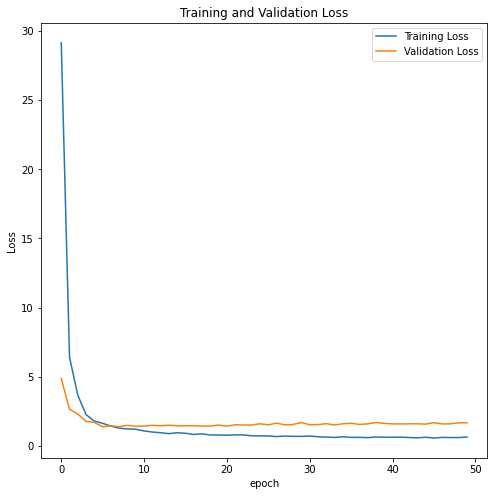

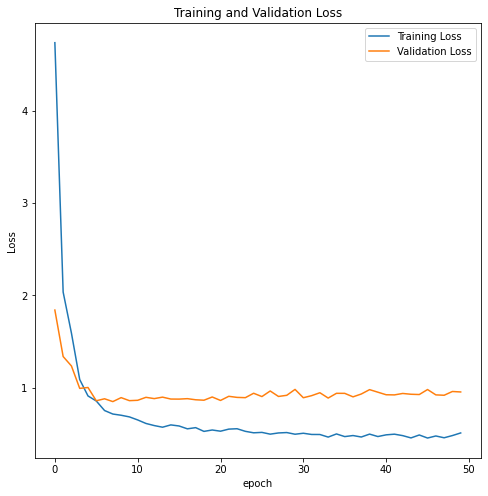

------------------------------------------------------------------------
Training for fold 4, seed 1100 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 3s 5ms/sample - loss: 29.7146 - mean_absolute_error: 4.7805 - val_loss: 7.2293 - val_mean_absolute_error: 2.2611
Epoch 2/50
568/568 [==============================] - 1s 2ms/sample - loss: 5.9889 - mean_absolute_error: 1.9744 - val_loss: 2.4119 - val_mean_absolute_error: 1.1593
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.7780 - mean_absolute_error: 1.5884 - val_loss: 2.7010 - val_mean_absolute_error: 1.3655
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.3051 - mean_absolute_error: 1.0909 - val_loss: 2.7134 - val_mean_absolute_error: 1.2933
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.9073 - mean_absolute_error: 0.9581 - val_loss: 2.1700 - val_mean_absolute_error: 1.1066
Epoch 6/50
568/

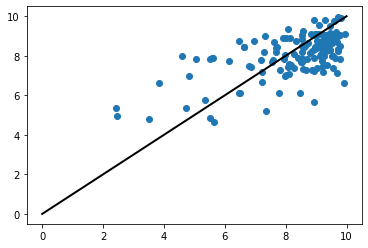

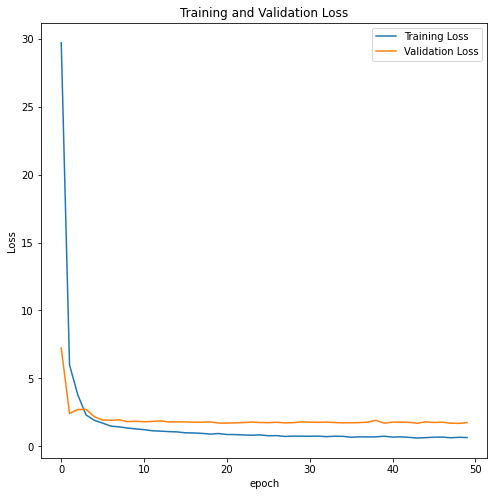

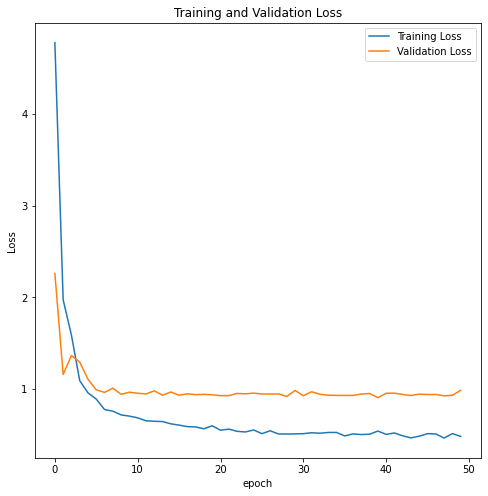

------------------------------------------------------------------------
Training for fold 5, seed 1100 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 16ms/sample - loss: 29.9860 - mean_absolute_error: 4.8504 - val_loss: 4.2006 - val_mean_absolute_error: 1.6431
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 6.3536 - mean_absolute_error: 2.0040 - val_loss: 3.4959 - val_mean_absolute_error: 1.4013
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.1000 - mean_absolute_error: 1.4203 - val_loss: 2.5944 - val_mean_absolute_error: 1.2659
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.1003 - mean_absolute_error: 1.0719 - val_loss: 2.3565 - val_mean_absolute_error: 1.0798
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.7123 - mean_absolute_error: 0.9064 - val_loss: 2.1822 - val_mean_absolute_error: 1.0569
Epoch 6/50
568

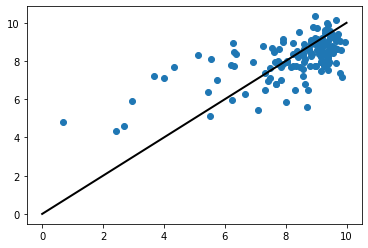

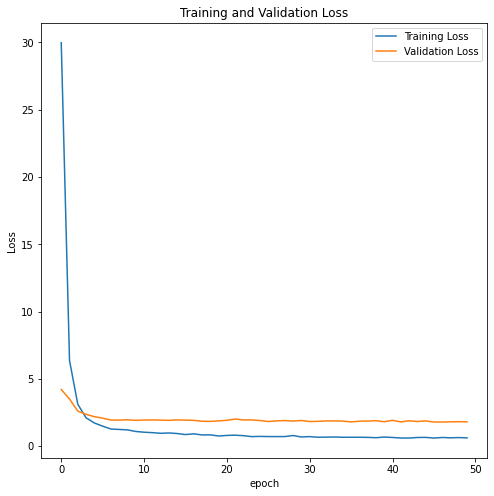

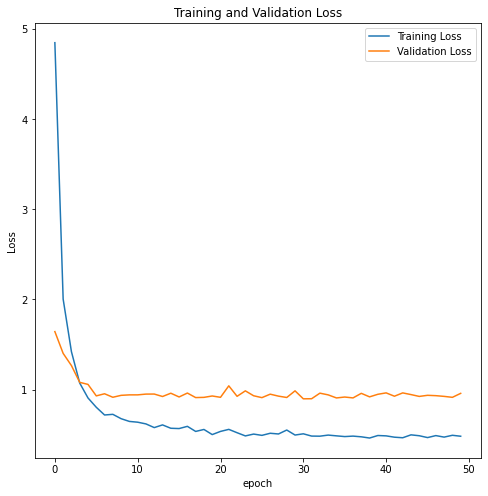

Overall spearman correlation: 0.493
------------------------------------------------------------------------
Training for fold 1, seed 1200 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 15ms/sample - loss: 30.4339 - mean_absolute_error: 4.8823 - val_loss: 5.0307 - val_mean_absolute_error: 1.8198
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 5.9367 - mean_absolute_error: 1.9440 - val_loss: 3.7415 - val_mean_absolute_error: 1.3622
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.3266 - mean_absolute_error: 1.4811 - val_loss: 3.2788 - val_mean_absolute_error: 1.3964
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.9235 - mean_absolute_error: 0.9936 - val_loss: 2.9882 - val_mean_absolute_error: 1.1926
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.6716 - mean_absolute_error: 0.9041 - val_loss: 2.6120 - val_mean_a

Epoch 49/50
568/568 [==============================] - 2s 4ms/sample - loss: 0.5948 - mean_absolute_error: 0.4805 - val_loss: 2.3512 - val_mean_absolute_error: 0.9527
Epoch 50/50
568/568 [==============================] - 2s 4ms/sample - loss: 0.5711 - mean_absolute_error: 0.4609 - val_loss: 2.3373 - val_mean_absolute_error: 1.0041
Spearman correlation: 0.641


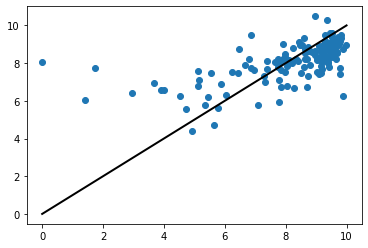

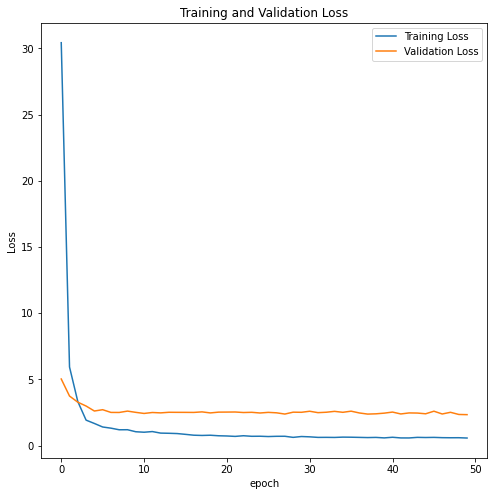

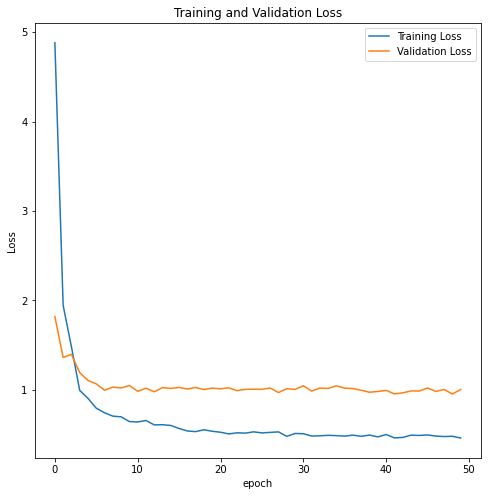

------------------------------------------------------------------------
Training for fold 2, seed 1200 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 8s 15ms/sample - loss: 29.7361 - mean_absolute_error: 4.8082 - val_loss: 5.6128 - val_mean_absolute_error: 1.8958
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 5.9897 - mean_absolute_error: 1.9839 - val_loss: 3.3087 - val_mean_absolute_error: 1.3664
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.1943 - mean_absolute_error: 1.4809 - val_loss: 3.0349 - val_mean_absolute_error: 1.3919
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.9919 - mean_absolute_error: 1.0193 - val_loss: 2.7876 - val_mean_absolute_error: 1.1466
Epoch 5/50
568/568 [==============================] - 1s 3ms/sample - loss: 1.6937 - mean_absolute_error: 0.9152 - val_loss: 2.4750 - val_mean_absolute_error: 1.1360
Epoch 6/50
568

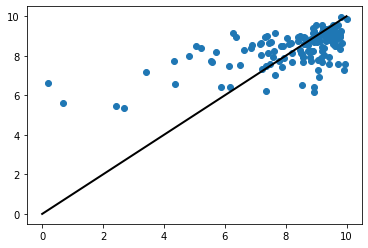

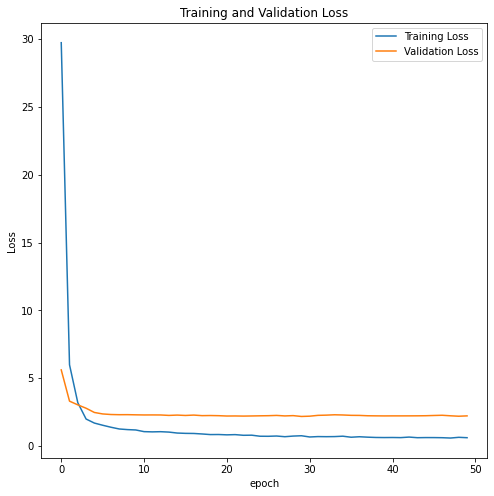

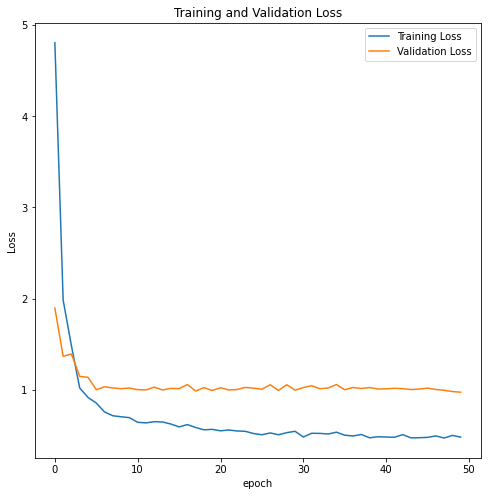

------------------------------------------------------------------------
Training for fold 3, seed 1200 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 17ms/sample - loss: 29.8798 - mean_absolute_error: 4.8276 - val_loss: 6.5962 - val_mean_absolute_error: 2.1637
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 6.4624 - mean_absolute_error: 2.0507 - val_loss: 2.6460 - val_mean_absolute_error: 1.1905
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.3612 - mean_absolute_error: 1.4992 - val_loss: 2.8437 - val_mean_absolute_error: 1.3974
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.0630 - mean_absolute_error: 1.0386 - val_loss: 2.4507 - val_mean_absolute_error: 1.1773
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.8435 - mean_absolute_error: 0.9359 - val_loss: 2.0789 - val_mean_absolute_error: 1.0686
Epoch 6/50
568

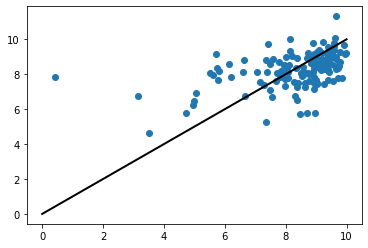

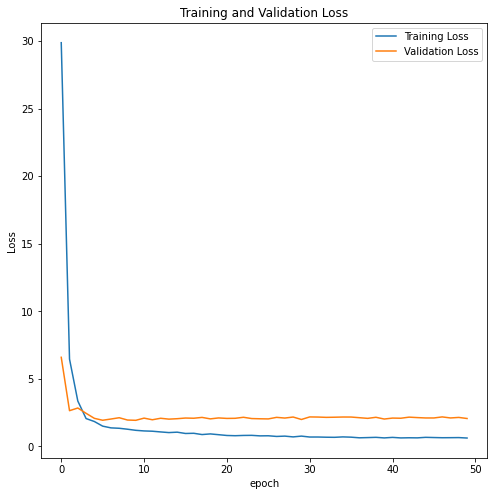

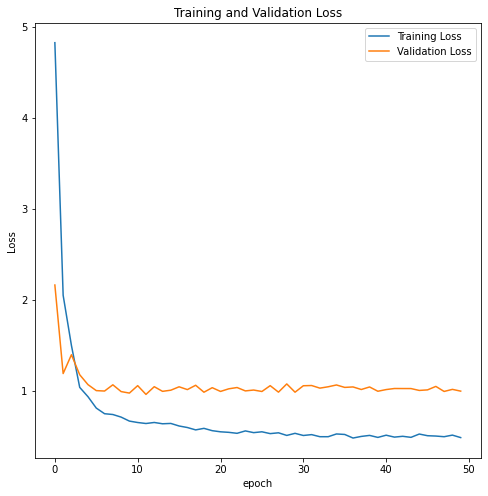

------------------------------------------------------------------------
Training for fold 4, seed 1200 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 8s 14ms/sample - loss: 30.3121 - mean_absolute_error: 4.8510 - val_loss: 5.2957 - val_mean_absolute_error: 1.8929
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 6.0800 - mean_absolute_error: 1.9766 - val_loss: 2.9196 - val_mean_absolute_error: 1.2711
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.4059 - mean_absolute_error: 1.4786 - val_loss: 2.8080 - val_mean_absolute_error: 1.3938
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.0059 - mean_absolute_error: 1.0139 - val_loss: 2.1034 - val_mean_absolute_error: 1.0662
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.7520 - mean_absolute_error: 0.9168 - val_loss: 1.8841 - val_mean_absolute_error: 1.0333
Epoch 6/50
568

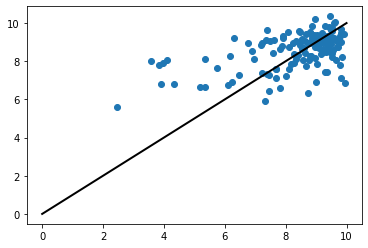

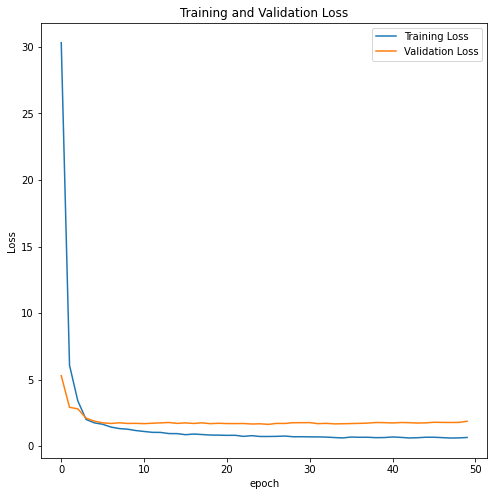

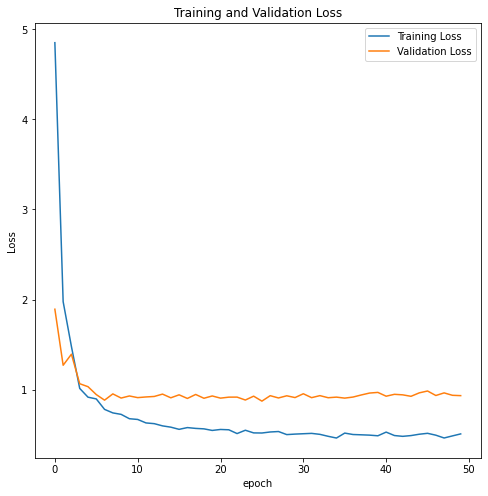

------------------------------------------------------------------------
Training for fold 5, seed 1200 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 8s 15ms/sample - loss: 30.3126 - mean_absolute_error: 4.8533 - val_loss: 5.5334 - val_mean_absolute_error: 1.9472
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 6.4526 - mean_absolute_error: 2.0521 - val_loss: 2.2187 - val_mean_absolute_error: 1.1579
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.8082 - mean_absolute_error: 1.5715 - val_loss: 2.8793 - val_mean_absolute_error: 1.4159
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.2549 - mean_absolute_error: 1.1000 - val_loss: 2.2601 - val_mean_absolute_error: 1.1641
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.9728 - mean_absolute_error: 0.9624 - val_loss: 1.8527 - val_mean_absolute_error: 1.0372
Epoch 6/50
568

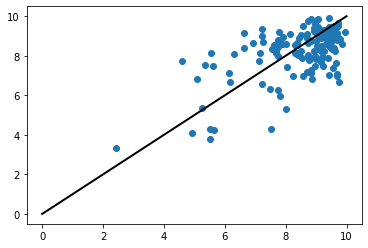

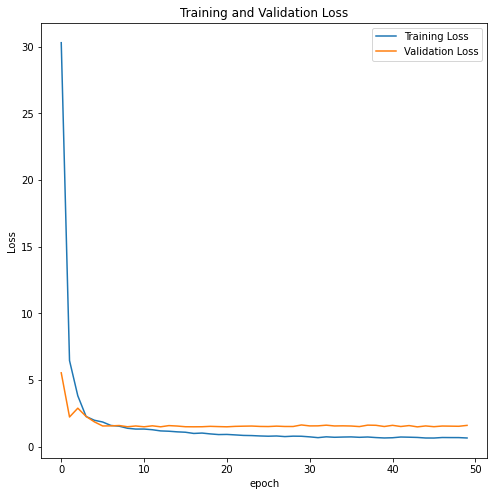

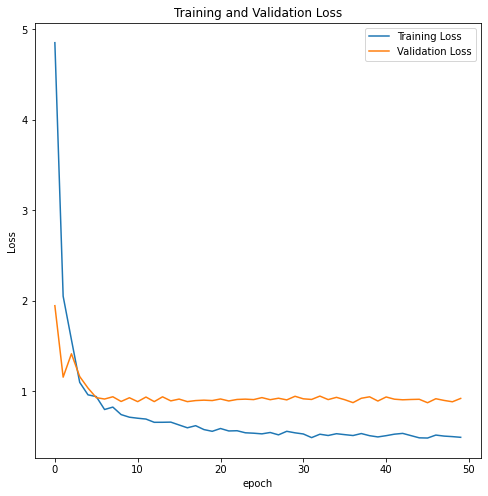

Overall spearman correlation: 0.489
------------------------------------------------------------------------
Training for fold 1, seed 1300 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 8s 14ms/sample - loss: 29.6908 - mean_absolute_error: 4.7752 - val_loss: 4.4109 - val_mean_absolute_error: 1.6621
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 5.5957 - mean_absolute_error: 1.8514 - val_loss: 2.7390 - val_mean_absolute_error: 1.2950
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.3896 - mean_absolute_error: 1.5067 - val_loss: 2.4931 - val_mean_absolute_error: 1.2540
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.0966 - mean_absolute_error: 1.0576 - val_loss: 2.2091 - val_mean_absolute_error: 1.1164
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.6268 - mean_absolute_error: 0.8604 - val_loss: 1.9501 - val_mean_a

Epoch 49/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.5990 - mean_absolute_error: 0.4756 - val_loss: 1.6325 - val_mean_absolute_error: 0.8774
Epoch 50/50
568/568 [==============================] - 1s 2ms/sample - loss: 0.6045 - mean_absolute_error: 0.4743 - val_loss: 1.6522 - val_mean_absolute_error: 0.8935
Spearman correlation: 0.496


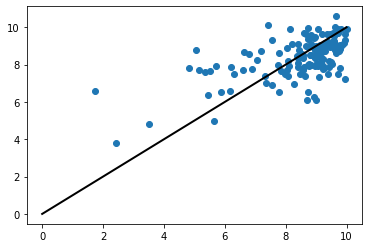

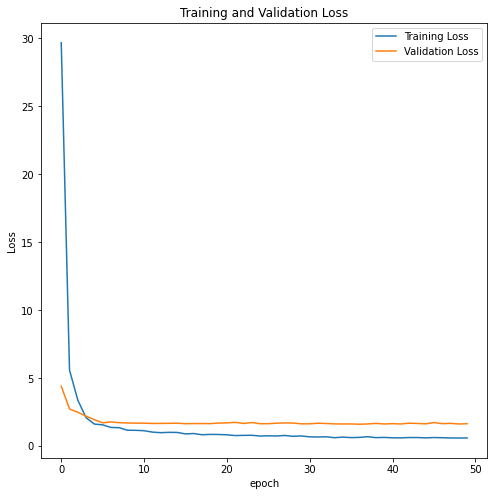

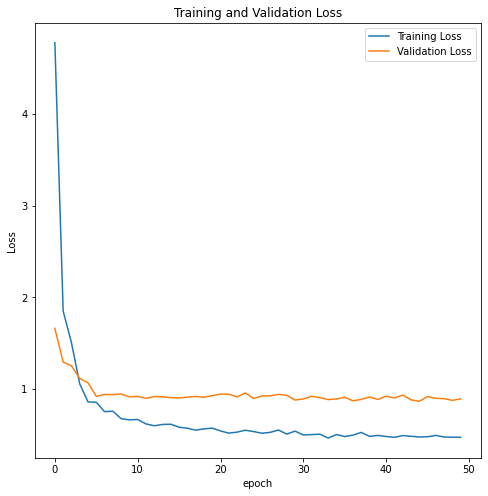

------------------------------------------------------------------------
Training for fold 2, seed 1300 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 15ms/sample - loss: 30.1034 - mean_absolute_error: 4.8380 - val_loss: 6.4109 - val_mean_absolute_error: 2.1864
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 6.0292 - mean_absolute_error: 2.0118 - val_loss: 4.3436 - val_mean_absolute_error: 1.4463
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.3530 - mean_absolute_error: 1.5235 - val_loss: 3.5874 - val_mean_absolute_error: 1.4621
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.9801 - mean_absolute_error: 1.0308 - val_loss: 3.3808 - val_mean_absolute_error: 1.2283
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.7295 - mean_absolute_error: 0.9331 - val_loss: 3.0026 - val_mean_absolute_error: 1.2061
Epoch 6/50
568

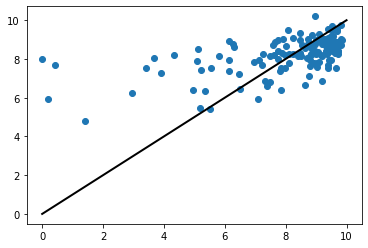

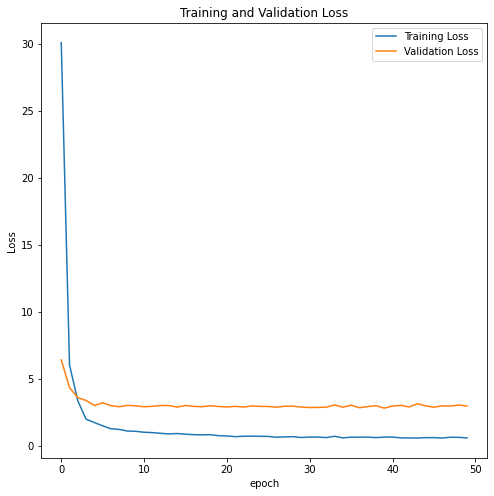

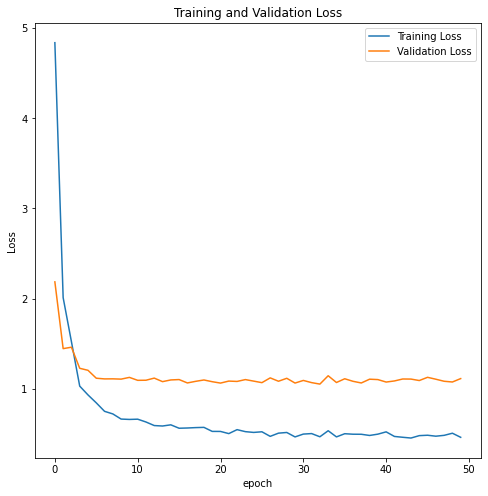

------------------------------------------------------------------------
Training for fold 3, seed 1300 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 8s 15ms/sample - loss: 29.1551 - mean_absolute_error: 4.7254 - val_loss: 5.4537 - val_mean_absolute_error: 1.8739
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 5.8974 - mean_absolute_error: 1.9322 - val_loss: 2.6236 - val_mean_absolute_error: 1.2809
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.6387 - mean_absolute_error: 1.5660 - val_loss: 2.4173 - val_mean_absolute_error: 1.2432
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.1884 - mean_absolute_error: 1.0486 - val_loss: 2.0398 - val_mean_absolute_error: 1.0617
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.8829 - mean_absolute_error: 0.9515 - val_loss: 1.8360 - val_mean_absolute_error: 1.0031
Epoch 6/50
568

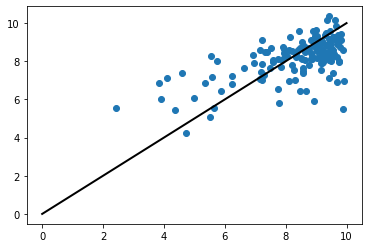

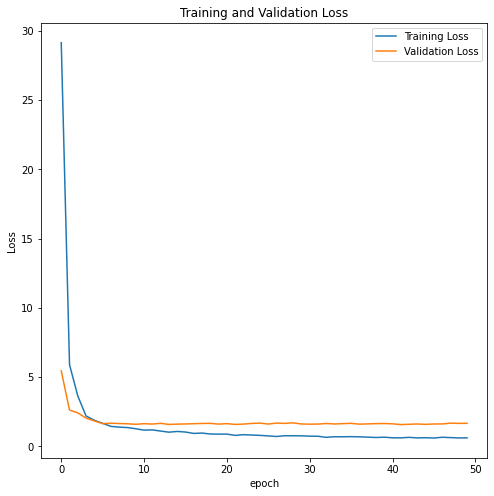

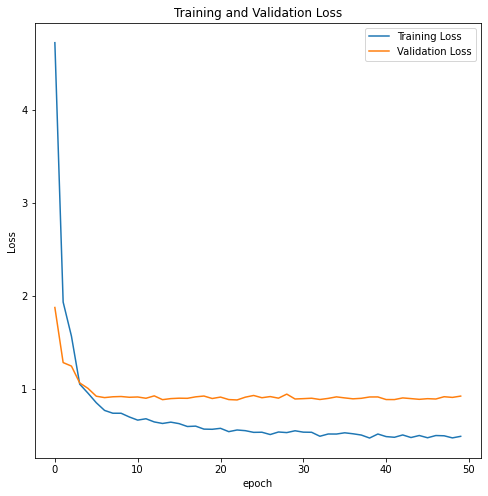

------------------------------------------------------------------------
Training for fold 4, seed 1300 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 15ms/sample - loss: 29.1576 - mean_absolute_error: 4.7254 - val_loss: 5.5571 - val_mean_absolute_error: 1.9579
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 5.9544 - mean_absolute_error: 1.9765 - val_loss: 2.6939 - val_mean_absolute_error: 1.3252
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.5028 - mean_absolute_error: 1.5474 - val_loss: 2.4364 - val_mean_absolute_error: 1.2869
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.1555 - mean_absolute_error: 1.0743 - val_loss: 2.0831 - val_mean_absolute_error: 1.0630
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.8381 - mean_absolute_error: 0.9180 - val_loss: 1.7542 - val_mean_absolute_error: 0.9931
Epoch 6/50
568

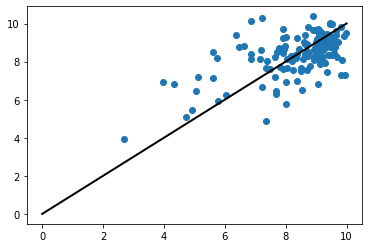

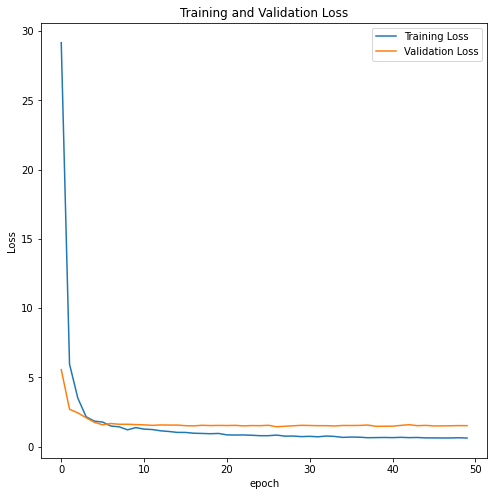

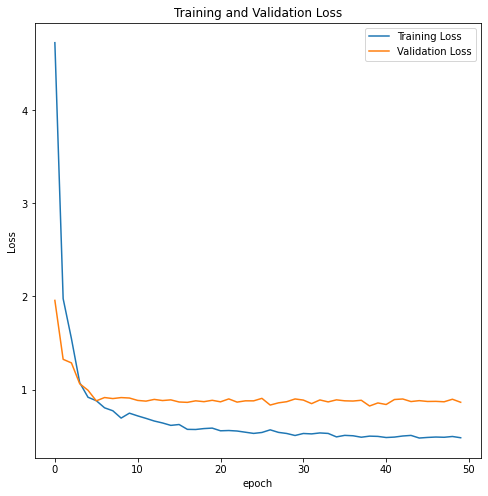

------------------------------------------------------------------------
Training for fold 5, seed 1300 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 8s 15ms/sample - loss: 29.0248 - mean_absolute_error: 4.7356 - val_loss: 5.1911 - val_mean_absolute_error: 1.9326
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 5.7154 - mean_absolute_error: 1.9268 - val_loss: 2.8501 - val_mean_absolute_error: 1.2482
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.3216 - mean_absolute_error: 1.5075 - val_loss: 2.6031 - val_mean_absolute_error: 1.2845
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.0747 - mean_absolute_error: 1.0440 - val_loss: 2.2983 - val_mean_absolute_error: 1.1114
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.6977 - mean_absolute_error: 0.8703 - val_loss: 2.0358 - val_mean_absolute_error: 1.0604
Epoch 6/50
568

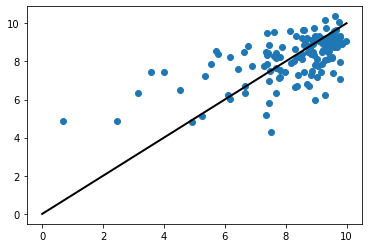

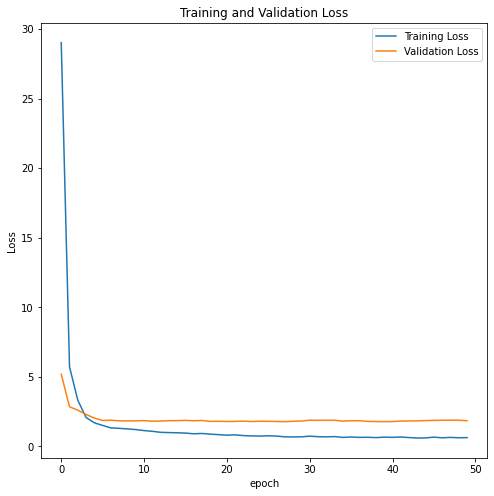

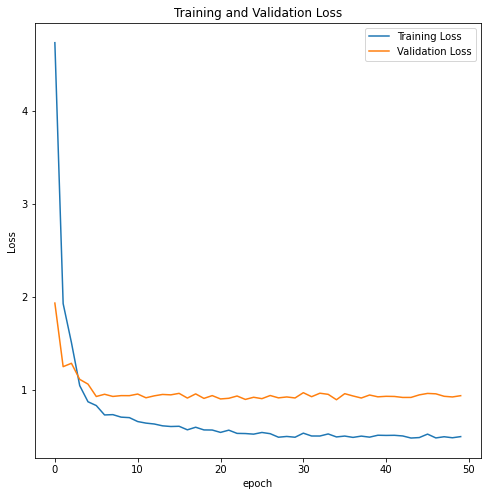

Overall spearman correlation: 0.513
------------------------------------------------------------------------
Training for fold 1, seed 1400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 16ms/sample - loss: 25.6094 - mean_absolute_error: 4.3558 - val_loss: 8.0067 - val_mean_absolute_error: 2.4544
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 5.8816 - mean_absolute_error: 1.9151 - val_loss: 3.1574 - val_mean_absolute_error: 1.4558
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.6362 - mean_absolute_error: 1.5733 - val_loss: 2.1739 - val_mean_absolute_error: 1.0999
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.0652 - mean_absolute_error: 1.0248 - val_loss: 2.1400 - val_mean_absolute_error: 1.0888
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.6394 - mean_absolute_error: 0.8688 - val_loss: 1.9227 - val_mean_a

Epoch 49/50
568/568 [==============================] - 2s 4ms/sample - loss: 0.6465 - mean_absolute_error: 0.5014 - val_loss: 1.7289 - val_mean_absolute_error: 0.8826
Epoch 50/50
568/568 [==============================] - 2s 4ms/sample - loss: 0.6003 - mean_absolute_error: 0.4572 - val_loss: 1.6608 - val_mean_absolute_error: 0.8547
Spearman correlation: 0.552


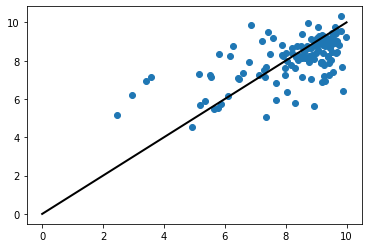

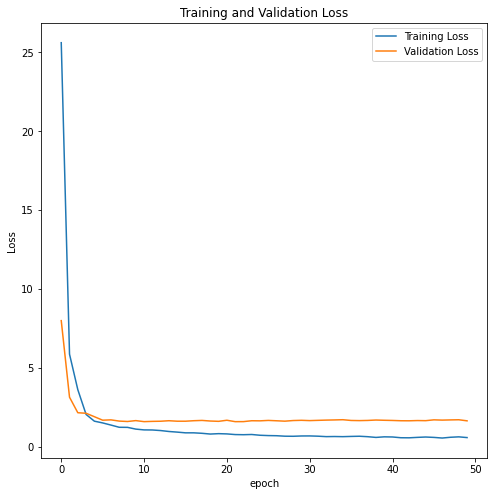

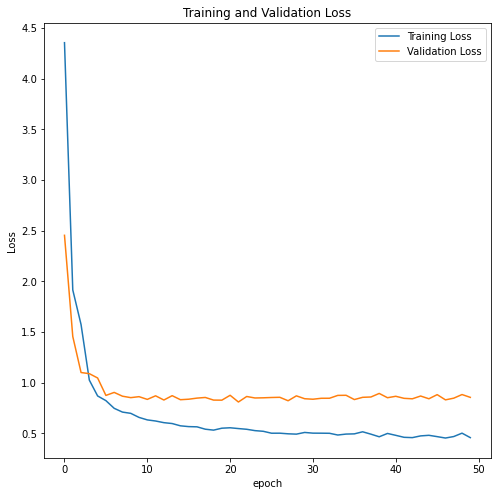

------------------------------------------------------------------------
Training for fold 2, seed 1400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 16ms/sample - loss: 26.8831 - mean_absolute_error: 4.5186 - val_loss: 6.3117 - val_mean_absolute_error: 2.1738
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 6.1286 - mean_absolute_error: 1.9667 - val_loss: 4.1304 - val_mean_absolute_error: 1.5701
Epoch 3/50
568/568 [==============================] - 3s 5ms/sample - loss: 3.8919 - mean_absolute_error: 1.6630 - val_loss: 2.6547 - val_mean_absolute_error: 1.2179
Epoch 4/50
568/568 [==============================] - 3s 5ms/sample - loss: 2.3561 - mean_absolute_error: 1.1504 - val_loss: 2.8174 - val_mean_absolute_error: 1.1767
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.6942 - mean_absolute_error: 0.8942 - val_loss: 2.4576 - val_mean_absolute_error: 1.1021
Epoch 6/50
568

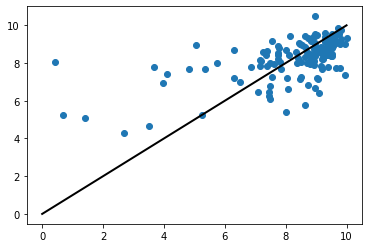

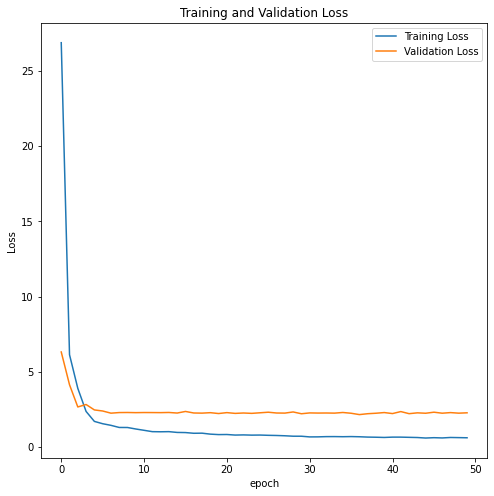

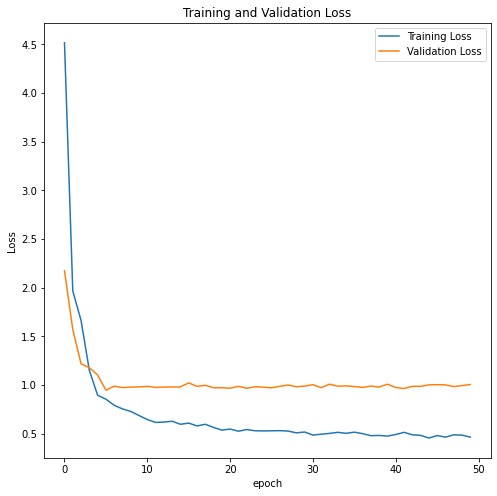

------------------------------------------------------------------------
Training for fold 3, seed 1400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 15ms/sample - loss: 25.6794 - mean_absolute_error: 4.3058 - val_loss: 6.6403 - val_mean_absolute_error: 2.2527
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 5.7191 - mean_absolute_error: 1.9297 - val_loss: 4.0417 - val_mean_absolute_error: 1.6659
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.7981 - mean_absolute_error: 1.6153 - val_loss: 2.4312 - val_mean_absolute_error: 1.1398
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.1858 - mean_absolute_error: 1.0795 - val_loss: 2.3913 - val_mean_absolute_error: 1.0257
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.6799 - mean_absolute_error: 0.9179 - val_loss: 2.3734 - val_mean_absolute_error: 1.1228
Epoch 6/50
568

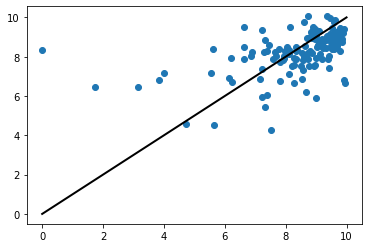

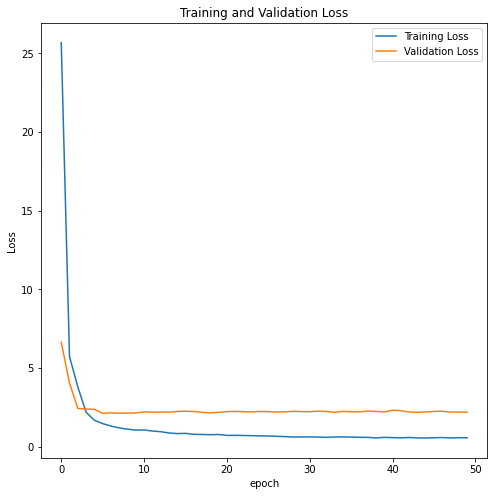

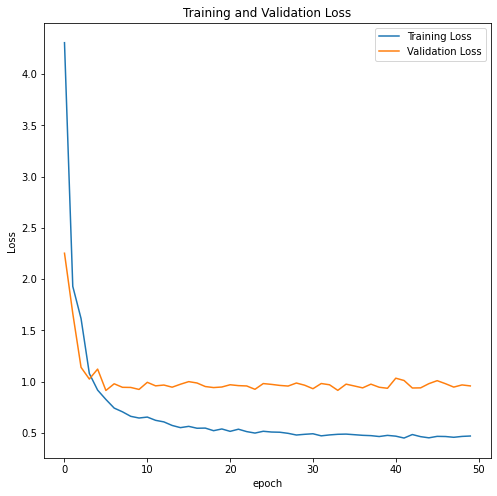

------------------------------------------------------------------------
Training for fold 4, seed 1400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 16ms/sample - loss: 26.3789 - mean_absolute_error: 4.4618 - val_loss: 6.9359 - val_mean_absolute_error: 2.2548
Epoch 2/50
568/568 [==============================] - 2s 3ms/sample - loss: 5.8018 - mean_absolute_error: 1.9487 - val_loss: 3.5772 - val_mean_absolute_error: 1.5924
Epoch 3/50
568/568 [==============================] - 1s 2ms/sample - loss: 3.6660 - mean_absolute_error: 1.5877 - val_loss: 2.3644 - val_mean_absolute_error: 1.2405
Epoch 4/50
568/568 [==============================] - 1s 2ms/sample - loss: 2.0551 - mean_absolute_error: 1.0257 - val_loss: 2.2581 - val_mean_absolute_error: 1.1537
Epoch 5/50
568/568 [==============================] - 1s 2ms/sample - loss: 1.6004 - mean_absolute_error: 0.8654 - val_loss: 2.2102 - val_mean_absolute_error: 1.1897
Epoch 6/50
568

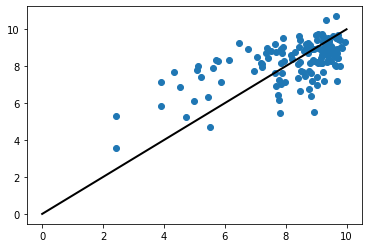

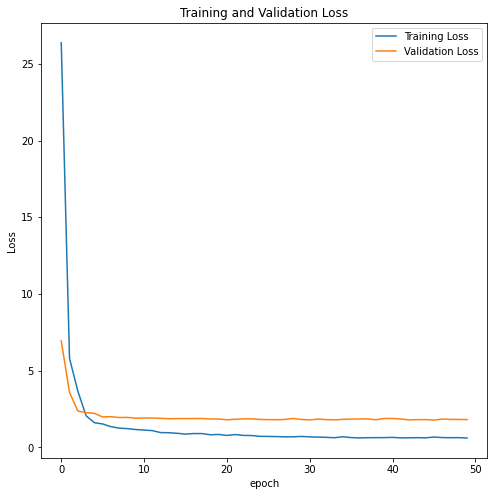

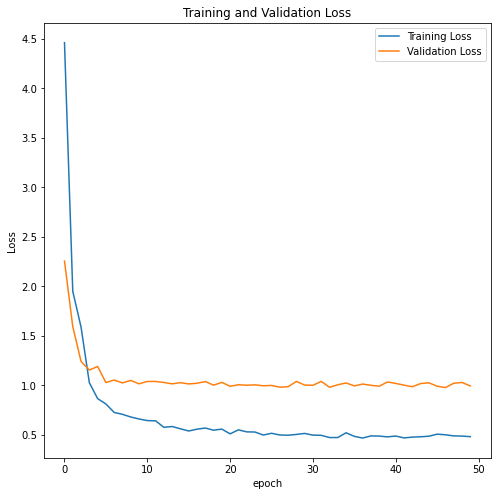

------------------------------------------------------------------------
Training for fold 5, seed 1400 ...
Train on 568 samples, validate on 142 samples
Epoch 1/50
568/568 [==============================] - 9s 16ms/sample - loss: 26.1770 - mean_absolute_error: 4.4056 - val_loss: 7.8426 - val_mean_absolute_error: 2.3462
Epoch 2/50
568/568 [==============================] - 2s 4ms/sample - loss: 6.1002 - mean_absolute_error: 1.9213 - val_loss: 2.8773 - val_mean_absolute_error: 1.3748
Epoch 3/50
568/568 [==============================] - 2s 4ms/sample - loss: 3.5947 - mean_absolute_error: 1.5666 - val_loss: 2.1111 - val_mean_absolute_error: 1.1185
Epoch 4/50
568/568 [==============================] - 2s 4ms/sample - loss: 2.1587 - mean_absolute_error: 1.0545 - val_loss: 2.1302 - val_mean_absolute_error: 1.0403
Epoch 5/50
568/568 [==============================] - 2s 4ms/sample - loss: 1.7674 - mean_absolute_error: 0.9223 - val_loss: 1.9183 - val_mean_absolute_error: 1.0414
Epoch 6/50
568

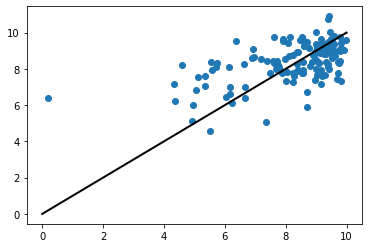

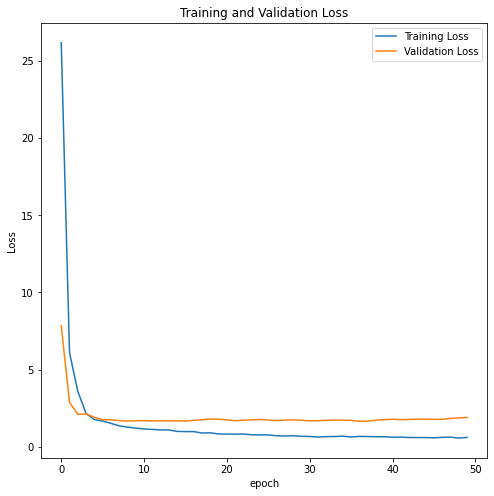

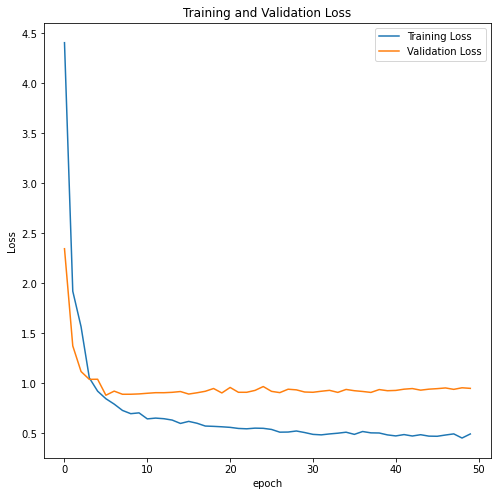

Overall spearman correlation: 0.523


In [38]:
##### use mse as the loss function ####

k = 5

overall_cor_res = []

for seed_num in range(400,1500,100):

    # Define the K-fold Cross Validator
    kfold = StratifiedKFold(n_splits=k, random_state= seed_num, shuffle=True)

    loss = []
    val_loss = []
    mse = []
    val_mse = []
    exp_train = [0]*k
    exp_test = [0]*k
    auc_train = [0]*k
    auc_test = [0]*k
    pred_res = []
    

    # K-fold Cross Validation model evaluation
    fold_no = 0
    for train_index, test_index in kfold.split(exp,auc_bi):
   
    
        # split dataset
        exp_train[fold_no], exp_test[fold_no] = exp.iloc[train_index,:], exp.iloc[test_index,:]
        auc_train[fold_no], auc_test[fold_no] = auc_norm[train_index], auc_norm[test_index]=
        
        # normalize
        exp_train[fold_no] = Robust.fit_transform(exp_train[fold_no])
        exp_test[fold_no] = Robust.fit_transform(exp_test[fold_no])
    
    
        # Define the model architecture
        model = gdsc_model(activation1 = 'sigmoid',activation2 = "softplus",l2 = 0.0001,l1=0.0001,
                       opt = tf.keras.optimizers.Adam(learning_rate=0.001)
                       )
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {(fold_no+1)}, seed {seed_num} ...')

        # Fit data to model
        #es = EarlyStopping(monitor='val_loss', verbose=1, mode='min',patience=5) #  
        gdsc_train = model.fit(x=exp_train[fold_no], y=auc_train[fold_no], epochs=50, batch_size=32,#128
                                  validation_data=(exp_test[fold_no],auc_test[fold_no])) # ,callbacks=[es]

    
        # predict and evaluate
        pred = model.predict(exp_test[fold_no])
        pred = pd.DataFrame(pred)
        pred_res.append(pred)
        test = auc_test[fold_no].reset_index(drop = True)
        test = auc_test[fold_no]
        # print(R2(test,pred[0]))
    
        # calculate Pearson's correlation
        corr, _ = spearmanr(test, pred[0])
        print('Spearman correlation: %.3f' % corr)
    
        plt.scatter(test,pred[0])
        plt.plot([0,10], [0,10], 'k-', lw=2)
    
    
        # plot loss train and validate
        loss.append(gdsc_train.history['loss'])
        val_loss.append(gdsc_train.history['val_loss'])
        plt_loss(loss[fold_no],val_loss[fold_no],fold_no+1)
    
        # plot acc train and validate
        mse.append(gdsc_train.history['mean_absolute_error'])
        val_mse.append(gdsc_train.history['val_mean_absolute_error'])
        plt_loss(mse[fold_no],val_mse[fold_no],fold_no+1)

        # Increase fold number
        fold_no = fold_no + 1
    
    # test_all
    test_all = np.concatenate([auc_test[0],auc_test[1],auc_test[2],auc_test[3],auc_test[4]])#
    # pred_all 
    pred_all = pd.concat([pred_res[0],pred_res[1],pred_res[2],pred_res[3],pred_res[4]],axis = 0)#
    
    overall_cor, _ = spearmanr(test_all, pred_all)
    overall_cor_res.append(overall_cor)
    print('Overall spearman correlation: %.3f' % overall_cor)
    
    # break

In [39]:
overall_cor_res

[0.5199163889916357,
 0.5249078130017537,
 0.5284810212789441,
 0.49512127601965245,
 0.49559915411651034,
 0.5214977517536399,
 0.5139336774637048,
 0.49299000450355873,
 0.48943015711643956,
 0.5130930645757047,
 0.5227052778172873]

Train on 710 samples
Epoch 1/50
710/710 [==============================] - 2s 2ms/sample - loss: 25.6484 - mean_absolute_error: 4.2319
Epoch 2/50
710/710 [==============================] - 1s 1ms/sample - loss: 5.3506 - mean_absolute_error: 1.6396
Epoch 3/50
710/710 [==============================] - 1s 1ms/sample - loss: 3.5778 - mean_absolute_error: 1.3010
Epoch 4/50
710/710 [==============================] - 1s 1ms/sample - loss: 2.6887 - mean_absolute_error: 0.9869
Epoch 5/50
710/710 [==============================] - 1s 2ms/sample - loss: 2.4189 - mean_absolute_error: 0.8876
Epoch 6/50
710/710 [==============================] - 1s 1ms/sample - loss: 2.2910 - mean_absolute_error: 0.8390
Epoch 7/50
710/710 [==============================] - 1s 1ms/sample - loss: 2.1179 - mean_absolute_error: 0.7711
Epoch 8/50
710/710 [==============================] - 1s 1ms/sample - loss: 1.9790 - mean_absolute_error: 0.7182
Epoch 9/50
710/710 [==============================] - 1s 2ms/sample - loss

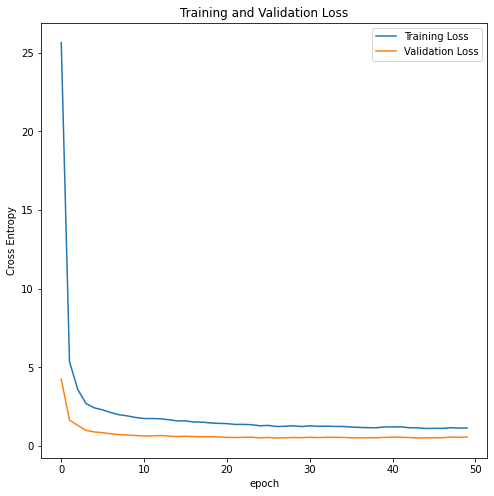

In [58]:
seed_num  = 1000

df_all = Robust.fit_transform(exp)

model_final = gdsc_model(activation1 = 'sigmoid',activation2 = "softplus",l2 = 0.0001,l1=0.0001,input_num = 10232,
                         opt = tf.keras.optimizers.Adam(learning_rate=0.001))

final_train = model_final.fit(x=df_all, y=auc_norm, epochs=50, batch_size=32) # ,validation_split=0.2

loss = final_train.history['loss']


mae = final_train.history['mean_absolute_error']


plt.figure(figsize=(8, 8))
plt.plot(loss, label='mse')
plt.plot(mae, label='mae')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('mse and mae Loss')
plt.xlabel('epoch')
plt.show()

model_final.save_weights("GDSC_model_oxaliplatin.h5")